In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import warnings
import seaborn as sns

import sys
sys.path.append('D:\Рабочий стол\DS\Крученные рельсы\projects\9684_dev\my_rail_analysis')

plt.style.use('dark_background')

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 12
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 10
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 12
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 10
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 16
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

warnings.filterwarnings('ignore')


In [8]:
file_path = r'\\ZSMK-9684-001\Data\DS\vasiliev_sa\data by crate\dzr_data_90ХАФ_with_wbf_stan.csv'
df = pd.read_csv(file_path, sep=',')
df.head(5)

,Unnamed: 0,tbk_TBK_1_h_ni_0_3_min,tbk_TBK_1_h_ni_0_3_max,tbk_TBK_1_h_ni_0_3_std,tbk_TBK_1_h_ni_0_3_mean,tbk_TBK_1_h_ni_0_3_median,tbk_TBK_1_h_ni_0_3_tg,tbk_TBK_1_h_ni_0_3_q1,tbk_TBK_1_h_ni_0_3_q3,tbk_TBK_1_h_ni_0_3_moda,...,to_c2,to_c3,to_c4,tpz_c1,tpz_c2,tpz_c3,tpz_c4,Вр.проката,brute_time,class
0,Л28705301_2023,179.88,181.13,0.188891,180.500258,180.43,-0.132791,180.40,180.53,180.39,...,839.0,839.0,820.0,584.0,575.0,568.0,631.0,2023-12-02 04:40:00,2023-12-02 04:30:00,no_defects
1,Л26955101_2023,179.94,181.05,0.216383,180.342923,180.26,-0.161053,180.24,180.30,180.26,...,832.0,827.0,813.0,613.0,566.0,574.0,614.0,2023-09-19 17:02:00,2023-09-19 16:20:00,no_defects
2,Л26915402_2023,179.71,181.01,0.226489,180.273054,180.20,-0.151340,180.18,180.24,180.20,...,834.0,832.0,814.0,617.0,568.0,575.0,615.0,2023-09-18 15:50:00,2023-09-18 15:20:00,no_defects
3,Л26949403_2023,180.02,180.92,0.206556,180.300684,180.23,-0.202176,180.18,180.37,180.19,...,840.0,832.0,831.0,603.0,572.0,564.0,595.0,2023-09-19 06:28:00,2023-09-19 06:20:00,no_defects
4,Л28050102_2023,179.71,181.74,0.481500,180.155128,179.94,-0.351089,179.92,180.13,179.88,...,839.0,836.0,830.0,584.0,574.0,576.0,620.0,2023-11-04 05:54:00,2023-11-04 05:40:00,no_defects


In [9]:
df.rename(columns={'Unnamed: 0': 'billet_id'}, inplace=True)
# Устанавливаем время проката в индекс
df.set_index('Вр.проката', inplace=True)

In [10]:
df.dtypes

billet_id                   object
tbk_TBK_1_h_ni_0_3_min     float64
tbk_TBK_1_h_ni_0_3_max     float64
tbk_TBK_1_h_ni_0_3_std     float64
tbk_TBK_1_h_ni_0_3_mean    float64
                            ...   
tpz_c2                     float64
tpz_c3                     float64
tpz_c4                     float64
brute_time                  object
class                       object
Length: 10862, dtype: object

In [11]:
df.shape

(2218, 10862)

In [12]:
# Определим категориальные и числовые признаки

def numeric_categorical_columns(dataset):
    numeric_columns = dataset.select_dtypes(exclude=[np.object_]).columns.tolist()
    categorical_columns = dataset.select_dtypes(include=[np.object_]).columns.tolist()
    return numeric_columns, categorical_columns

numeric_columns, categorical_columns = numeric_categorical_columns(df)

### Проверим на пропуски

In [13]:
tmp = df.isna().sum().to_frame(name='nans')
tmp = tmp[tmp['nans'] > 500]
tmp

,nans
tbk_TBK_1_tm_ni_0_3_min,1063
tbk_TBK_1_tm_ni_0_3_max,1063
tbk_TBK_1_tm_ni_0_3_std,1063
tbk_TBK_1_tm_ni_0_3_mean,1063
tbk_TBK_1_tm_ni_0_3_median,1063
...,...
WBF_sgl_1_Z6_LV2_IN_percent_ni_single,830
WBF_sgl_1_Z7_LV2_IN_percent_ni_single,1017
WBF_sgl_1_Z8_LV2_IN_percent_ni_single,1017
WBF_sgl_1_Z9_LV2_IN_percent_ni_single,1017


In [14]:
# Удаление признаков с более чем половиной пропусков:

class MissingValuesHandler:
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.columns_dropped = []

    def drop_columns_with_many_missing_values(self, df):
        """
        Удаляет признаки с более чем указанным порогом пропусков.

        Параметры:
        - df: DataFrame, исходные данные.

        Возвращает:
        - DataFrame без удаленных признаков.
        """
        threshold = self.threshold * df.shape[0]
        self.columns_dropped = [col for col in df.columns if df[col].isna().sum() > threshold]
        return df.drop(columns=self.columns_dropped)

    def get_dropped_columns(self):
        """
        Возвращает список отброшенных признаков.

        Возвращает:
        - Список отброшенных признаков.
        """
        print(f"Кол-во отброшенных признаков: {len(self.columns_dropped)}")
        return self.columns_dropped

In [15]:
drop_half = MissingValuesHandler(threshold=0.2)
df = drop_half.drop_columns_with_many_missing_values(df)
drop_half.get_dropped_columns()

Кол-во отброшенных признаков: 10348


['tbk_TBK_1_tm_ni_0_3_min',
 'tbk_TBK_1_tm_ni_0_3_max',
 'tbk_TBK_1_tm_ni_0_3_std',
 'tbk_TBK_1_tm_ni_0_3_mean',
 'tbk_TBK_1_tm_ni_0_3_median',
 'tbk_TBK_1_tm_ni_0_3_tg',
 'tbk_TBK_1_tm_ni_0_3_q1',
 'tbk_TBK_1_tm_ni_0_3_q3',
 'tbk_TBK_1_tm_ni_0_3_moda',
 'tbk_TBK_1_tm_ni_0_3_q_deviation_aggregate',
 'tbk_TBK_1_tf_ni_0_3_min',
 'tbk_TBK_1_tf_ni_0_3_max',
 'tbk_TBK_1_tf_ni_0_3_std',
 'tbk_TBK_1_tf_ni_0_3_mean',
 'tbk_TBK_1_tf_ni_0_3_median',
 'tbk_TBK_1_tf_ni_0_3_tg',
 'tbk_TBK_1_tf_ni_0_3_q1',
 'tbk_TBK_1_tf_ni_0_3_q3',
 'tbk_TBK_1_tf_ni_0_3_moda',
 'tbk_TBK_1_tf_ni_0_3_q_deviation_aggregate',
 'tbk_TBK_1_fm_ni_0_3_min',
 'tbk_TBK_1_fm_ni_0_3_max',
 'tbk_TBK_1_fm_ni_0_3_std',
 'tbk_TBK_1_fm_ni_0_3_mean',
 'tbk_TBK_1_fm_ni_0_3_median',
 'tbk_TBK_1_fm_ni_0_3_tg',
 'tbk_TBK_1_fm_ni_0_3_q1',
 'tbk_TBK_1_fm_ni_0_3_q3',
 'tbk_TBK_1_fm_ni_0_3_moda',
 'tbk_TBK_1_fm_ni_0_3_q_deviation_aggregate',
 'tbk_TBK_1_ff_ni_0_3_min',
 'tbk_TBK_1_ff_ni_0_3_max',
 'tbk_TBK_1_ff_ni_0_3_std',
 'tbk_TBK_1_ff_n

In [16]:
df.shape

(2218, 514)

### Заполнение пропусков

In [17]:
# Получаем имена столбцов с пропущенными значениями
tmp = df.isna().sum().to_frame(name='nans')
tmp = tmp[tmp['nans'] != 0]
columns_with_missing_vals = tmp.index
len(columns_with_missing_vals)

341

In [18]:
# Заполнение пропусков, смотря на похожие объекты:
for col in columns_with_missing_vals:
    grouped_means = df.groupby('class')[col].transform('mean')
    df[col] = df[col].fillna(grouped_means)

### Отбрасываем константные и квазиконстантные признаки из датасета

In [19]:
from sklearn.feature_selection import VarianceThreshold

def drop_constant_features(dataset, threshold=0):
    """
    Отбрасывает константные и квазиконстантные признаки из датасета.

    Параметры:
    - dataset: DataFrame, исходный датасет.
    - threshold: float, порог дисперсии, ниже которого признаки считаются константными (по умолчанию 0).

    Возвращает:
    - dataset: DataFrame, датасет с отброшенными константными признаками.
    - constant_cols: list, список названий отброшенных признаков.
    """
    cutter = VarianceThreshold(threshold=threshold)
    cutter.fit(dataset)
    selected_features = cutter.get_support()
    constant_cols = dataset.columns[~selected_features].tolist()
    dataset = dataset.drop(columns=constant_cols, axis=1)
    return dataset, constant_cols

In [20]:
# Переопределю числовые и категориальные признаки
numeric_columns, categorical_columns = numeric_categorical_columns(df)

In [21]:
# Отбрасываю признаки, у которых дисперсия ниже 0.1
df_num, const = drop_constant_features(df[numeric_columns], 0.1)

In [22]:
# Кол-во отброшенных фичей по константному признаку
len(const)

188

In [23]:
df = pd.concat([df_num, df[categorical_columns]], axis=1)

### Посмотрим на коррелирующие признаки

In [24]:
def get_redundant_pairs(df):
    """
    Функция для определения пар признаков, для которых корреляция уже была рассчитана.

    Параметры:
    - df: DataFrame, содержащий признаки.

    Возвращает:
    - pairs_to_drop: множество, содержащее пары признаков, для которых корреляция уже была рассчитана.
    """
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """
    Функция для получения верхних абсолютных корреляций между признаками в DataFrame.

    Параметры:
    - df: DataFrame, содержащий признаки.
    - n: int, количество верхних корреляций для возврата (по умолчанию 5).

    Возвращает:
    - au_corr[:n]: Series, содержащий верхние абсолютные корреляции между признаками.
    """
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[:n]

def print_top_abs_correlations(df, n=5):
    """
    Функция для вывода верхних абсолютных корреляций между признаками в DataFrame.

    Параметры:
    - df: DataFrame, содержащий признаки.
    - n: int, количество верхних корреляций для вывода (по умолчанию 5).
    """
    print("Top Absolute Correlations:")
    top_corr = get_top_abs_correlations(df, n).reset_index()
    top_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
    print(top_corr)

In [25]:
# Переопределю числовые и категориальные признаки
numeric_columns, categorical_columns = numeric_categorical_columns(df)

In [26]:
# Верхние абсолютные корреляции между признаками
print_top_abs_correlations(df[numeric_columns], 10)

Top Absolute Correlations:
                         Feature 1                                 Feature 2  \
0    WBF_sgl_1_WEIGTH_IN_ni_single            WBF_sgl_1_WEIGHT_OUT_ni_single   
1    WBF_sgl_1_LENGTH_IN_ni_single            WBF_sgl_1_LENGTH_OUT_ni_single   
2        WBF_sgl_1_L_WBF_ni_single             WBF_sgl_1_LENGTH_IN_ni_single   
3        WBF_sgl_1_L_WBF_ni_single            WBF_sgl_1_LENGTH_OUT_ni_single   
4  WBF_sgl_1_TARGET_TEMP_ni_single  WBF_sgl_1_DCHG_TARGET_TEMP_PDI_ni_single   
5                             line                            Исп_секции_дзр   
6     WBF_sgl_1_STRATEGY_ni_single           WBF_sgl_1_TARGET_TEMP_ni_single   
7     WBF_sgl_1_STRATEGY_ni_single  WBF_sgl_1_DCHG_TARGET_TEMP_PDI_ni_single   
8     tbk_TBK_1_area_ni_0_0.29_min               tbk_TBK_1_kgm_ni_0_0.29_min   
9        tbk_TBK_1_area_ni_0_3_min                  tbk_TBK_1_kgm_ni_0_3_min   

   Correlation  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4      

In [27]:
def remove_highly_correlated_features(dataset, threshold):
    """
    Удаляет признаки с высокой корреляцией из датасета.

    Параметры:
    - dataset: DataFrame, исходный датасет.
    - threshold: float, порог корреляции, при котором признаки будут удалены.

    Возвращает:
    - dataset: DataFrame, датасет с удаленными признаками.
    """
    col_corr = set()  # Множество названий удаленных столбцов
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]  # Получение названия столбца
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname]  # Удаление столбца из датасета
    return dataset

In [28]:
df_num = remove_highly_correlated_features(df[numeric_columns], 0.7)

In [29]:
df = pd.concat([df_num, df[categorical_columns]], axis=1)

In [30]:
df.shape

(2218, 92)

In [35]:
# Переопределю числовые и категориальные признаки
numeric_columns, categorical_columns = numeric_categorical_columns(df)

### Жадный прямой отбор признаков

In [31]:
# Переведем категориальные признаки class в числовые
df['class_num'] = df['class'].apply(lambda x: 0 if x == 'no_defects' else 1)

### Имеем несбалансированные классы

In [32]:
df.groupby('class_num').size()

class_num
0    2126
1      92
dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

X = df[numeric_columns]
Y = df['class_num']

# Разделим данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

from mlxtend.feature_selection import SequentialFeatureSelector

feature_selector = SequentialFeatureSelector(LogisticRegression(max_iter=1000),
           k_features=50,
           forward=True,
           verbose=2,
           scoring='average_precision',
           cv=4)

In [39]:
features = feature_selector.fit(np.array(X), Y)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.7s

[2024-04-16 14:35:46] Features: 1/50 -- score: 0.23745538718285003[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.2s

[2024-04-16 14:35:49] Features: 2/50 -- score: 0.28703439449730006[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.6s

[2024-04-16 14:35:52] Features: 3/50 -- score: 0.3349018227798941[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s

[2024-04-16 14:35:57] Features: 4/50 -- score: 0.33461453659369644[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.3s

[2024-04-16 14:36:02] Features: 5/50 -- score: 0.34729006711628063[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.3s

[2024-04-16 14:36:11] Features: 6/50 -- score: 0.49692465983576806[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s

[2024-04-16 14:36:24] Features: 7/50 -- score: 0.5657094811028734[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.4s

[2024-04-16 14:36:43] Features: 8/50 -- scor

In [40]:
filtered_features= X.columns[list(features.k_feature_idx_)]
filtered_features

Index(['tbk_TBK_1_h_ni_0_3_max', 'tbk_TBK_1_area_ni_0_3_std',
       'tbk_TBK_1_h_ni_0_0.29_q1',
       'tbk_TBK_1_h_ni_0_0.29_q_deviation_aggregate',
       'tbk_TBK_1_area_ni_0.29_1_tg',
       'tbk_TBK_1_area_ni_0.29_1_q_deviation_aggregate',
       'tbk_TBK_1_area_ni_1_5.5_std', 'tbk_TBK_1_area_ni_1_5.5_tg',
       'tbk_TBK_1_area_ni_5.5_6.6_tg', 'tbk_TBK_1_area_ni_6.6_9.6_std',
       'tbk_TBK_1_area_ni_9.6_25_std', 'tbk_TBK_1_area_ni_25_30_std',
       'tbk_TBK_1_area_ni_25_30_tg',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_WBF_PIRO_1_min',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_WBF_PIRO_1_max',
       'mill_WBF_PIRO_1_TEMP_PIR2_ni_WBF_PIRO_1_max',
       'mill_WBF_PIRO_1_TEMP_PIR2_ni_WBF_PIRO_1_std',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_BEAM_VERT_ENC_3_std',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_BEAM_HOR_ENC_POS_2_std',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_ALL_PTS_1_max',
       'mill_WBF_PIRO_1_TEMP_PIR3_ni_ALL_PTS_1_std',
       'mill_WBF_PIRO_1_TEMP_PIR1_ni_ALL_PTS_1_min',
       'mil

In [42]:
filtered_features = [
        'tbk_TBK_1_h_ni_0_3_max', 'tbk_TBK_1_area_ni_0_3_std',
        'tbk_TBK_1_h_ni_0_0.29_q1',
        'tbk_TBK_1_h_ni_0_0.29_q_deviation_aggregate',
        'tbk_TBK_1_area_ni_0.29_1_tg',
        'tbk_TBK_1_area_ni_0.29_1_q_deviation_aggregate',
        'tbk_TBK_1_area_ni_1_5.5_std', 'tbk_TBK_1_area_ni_1_5.5_tg',
        'tbk_TBK_1_area_ni_5.5_6.6_tg', 'tbk_TBK_1_area_ni_6.6_9.6_std',
        'tbk_TBK_1_area_ni_9.6_25_std', 'tbk_TBK_1_area_ni_25_30_std',
        'tbk_TBK_1_area_ni_25_30_tg',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_WBF_PIRO_1_min',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_WBF_PIRO_1_max',
        'mill_WBF_PIRO_1_TEMP_PIR2_ni_WBF_PIRO_1_max',
        'mill_WBF_PIRO_1_TEMP_PIR2_ni_WBF_PIRO_1_std',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_BEAM_VERT_ENC_3_std',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_BEAM_HOR_ENC_POS_2_std',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_ALL_PTS_1_max',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_ALL_PTS_1_std',
        'mill_WBF_PIRO_1_TEMP_PIR1_ni_ALL_PTS_1_min',
        'mill_WBF_PIRO_1_TEMP_PIR1_ni_ALL_PTS_20_std',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_DM_ENC_HOR_POS_1_max',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_DM_ENC_HOR_POS_1_std',
        'mill_WBF_PIRO_1_TEMP_PIR3_ni_DM_ENC_HOR_POS_1_mean',
        'mill_WBF_PIRO_1_TEMP_PIR2_ni_DM_ENC_HOR_POS_1_mean',
        'mill_WBF_series_1_PHASE_ni_delta', 'mill_WBF_series_2_PHASE_ni_delta',
        'mill_WBF_series_4_PHASE_ni_delta', 'WBF_sgl_1_STRATEGY_ni_single',
        'WBF_sgl_1_W_WBF_ni_single', 'WBF_sgl_1_CUR_PACE_RATE_ni_single',
        'WBF_sgl_1_TARGET_MEAN_TEMP_HE2_ni_single',
        'WBF_sgl_1_CALC_DISCHARGING_TEMP_TOP_CENTR_ni_single',
        'WBF_sgl_1_C_MODE_PERC_ni_single', 'WBF_sgl_1_MAX_DELTA_TEMP_ni_single',
        'WBF_sgl_1_DELTA_T_CROSS_ni_single',
        'WBF_sgl_1_STRAND_NUMBER_ni_single', 'line', 'p_sec1_up', 'p_sec1_dwn',
        'p_sec2_dwn', 'Т_центр_дзр_мин', 'Т_центр_дзр_сред', 'to_c1', 'to_c2',
        'tpz_c2', 'tpz_c3', 'tpz_c4'
       ]

In [43]:
df_result = pd.concat([df[filtered_features], Y], axis=1)
df_result

,tbk_TBK_1_h_ni_0_3_max,tbk_TBK_1_area_ni_0_3_std,tbk_TBK_1_h_ni_0_0.29_q1,tbk_TBK_1_h_ni_0_0.29_q_deviation_aggregate,tbk_TBK_1_area_ni_0.29_1_tg,tbk_TBK_1_area_ni_0.29_1_q_deviation_aggregate,tbk_TBK_1_area_ni_1_5.5_std,tbk_TBK_1_area_ni_1_5.5_tg,tbk_TBK_1_area_ni_5.5_6.6_tg,tbk_TBK_1_area_ni_6.6_9.6_std,...,p_sec1_dwn,p_sec2_dwn,Т_центр_дзр_мин,Т_центр_дзр_сред,to_c1,to_c2,tpz_c2,tpz_c3,tpz_c4,class_num
Вр.проката,,,,,,,,,,,,,,,,,,,,,
2023-12-02 04:40:00,181.13,216.417034,180.965,0.0375,-27.966119,1.78500,8.660434,-2.782877,-20.035443,9.872071,...,33.934959,34.395378,300.0,872.0,821.0,839.0,575.0,568.0,631.0,0
2023-09-19 17:02:00,181.05,74.366446,180.970,0.0050,-33.352635,1.68500,5.411877,0.814464,-21.653092,10.658445,...,33.783352,33.866425,301.0,792.0,839.0,832.0,566.0,574.0,614.0,0
2023-09-18 15:50:00,181.01,72.755486,180.315,0.3475,-90.567765,14.13500,7.108826,2.016696,4.361365,6.529499,...,33.846252,34.338745,300.0,777.0,839.0,834.0,568.0,575.0,615.0,0
2023-09-19 06:28:00,180.92,72.555581,180.820,0.0050,-30.127775,1.81375,10.781713,1.957567,9.909465,3.063746,...,32.901402,34.492546,300.0,778.0,835.0,840.0,572.0,564.0,595.0,0
2023-11-04 05:54:00,181.74,197.764606,181.495,0.0550,-85.016963,12.59500,4.877770,0.966452,-25.087191,3.172810,...,34.180779,34.321232,300.0,878.0,822.0,839.0,574.0,576.0,620.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 14:58:00,180.89,65.277759,180.425,0.2325,-81.350374,8.22000,11.537185,0.666523,-4.121764,7.353874,...,32.891094,34.358791,302.0,774.0,833.0,840.0,576.0,565.0,603.0,0
2023-11-15 19:45:00,182.62,147.585094,181.730,0.1400,-78.474262,4.76250,6.093726,-0.255969,7.366221,3.965364,...,34.110703,34.502995,302.0,868.0,816.0,839.0,580.0,574.0,621.0,0
2023-10-16 07:20:00,180.71,34.016087,180.170,0.2700,-68.570235,8.84000,9.932771,3.283990,-2.610184,7.255487,...,33.330059,34.795769,301.0,887.0,831.0,829.0,565.0,565.0,616.0,1


### Проверка на выбросы (Визуализация признаков относительно таргета )

In [44]:
class NumericBoxPlot:
    def __init__(self, df, target_column):
        """
        ### Box-plot-ы распределений в разных классах

        Параметры:
        - df: DataFrame, исходные данные.
        - target_column: str, имя целевого признака.
        """
        self.df = df
        self.target_column = target_column

    def plot(self):
        """
        Визуализирует числовой признак относительно целевого признака с помощью boxplot.
        """
        numeric_columns = [col for col in self.df.columns if self.df[col].dtype != 'object']
        for col in numeric_columns:
            if col != self.target_column:
                fig = plt.figure()
                fig.set_size_inches(10, 8)
                sns.boxplot(y=self.df[col], x=self.df[self.target_column],
                            data=self.df, hue=self.target_column,
                            palette='Set2')
                plt.grid(True, alpha=0.2, linestyle="--")
                plt.show()

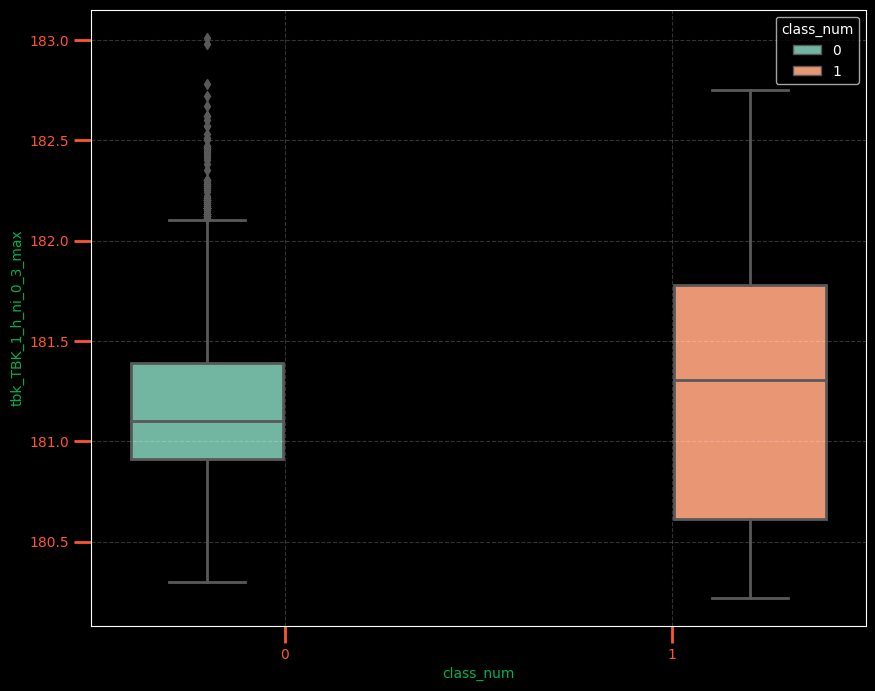

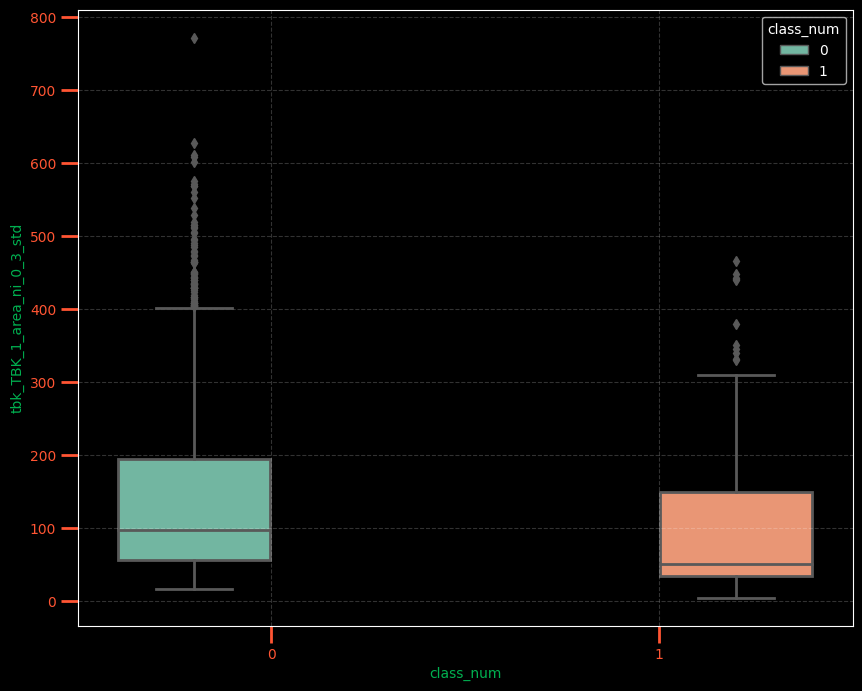

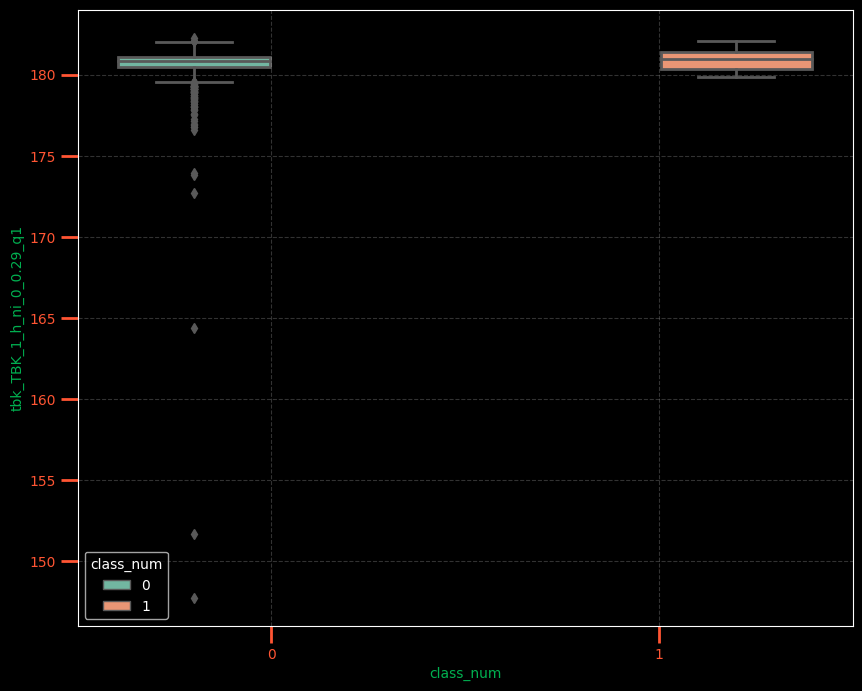

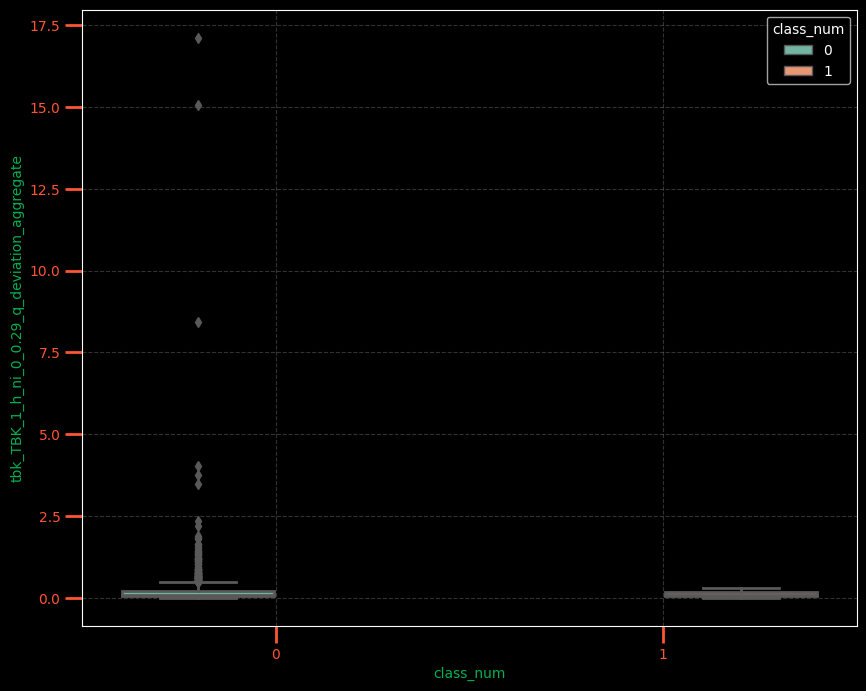

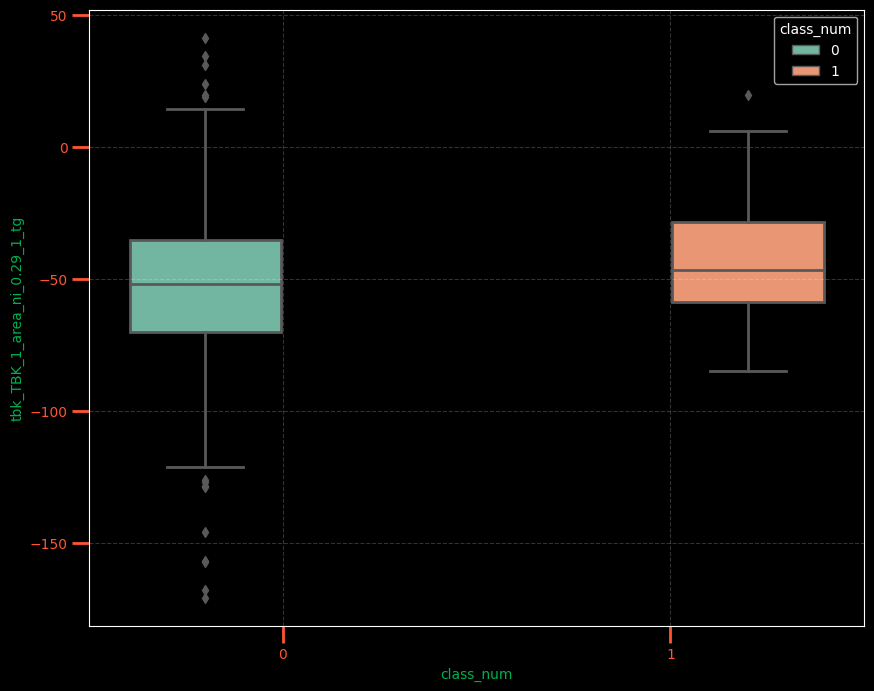

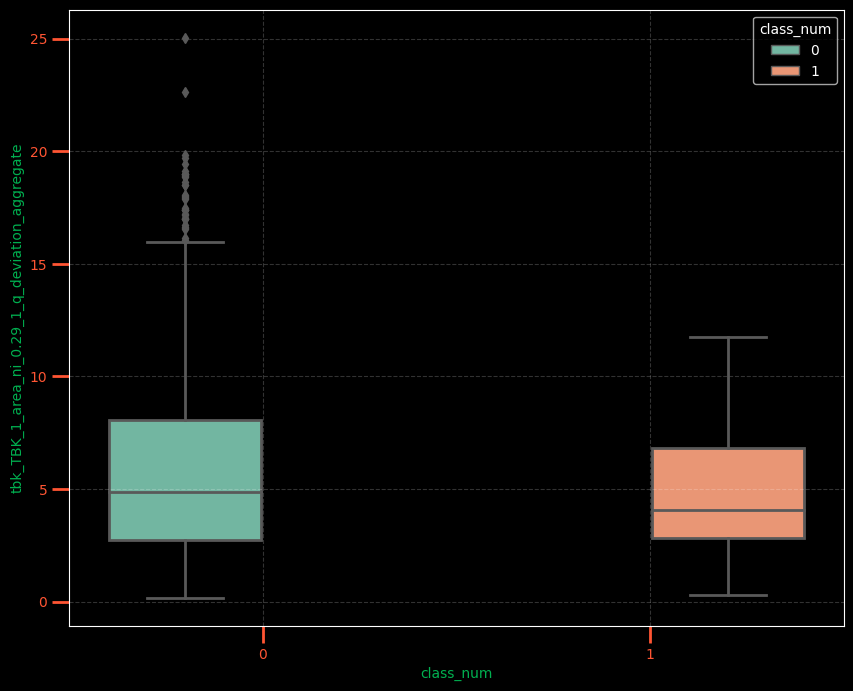

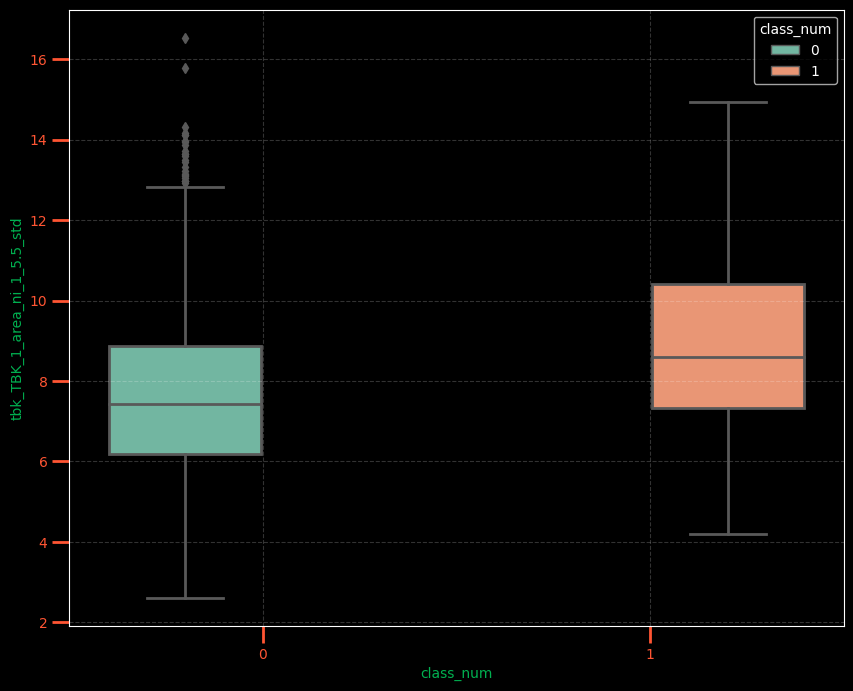

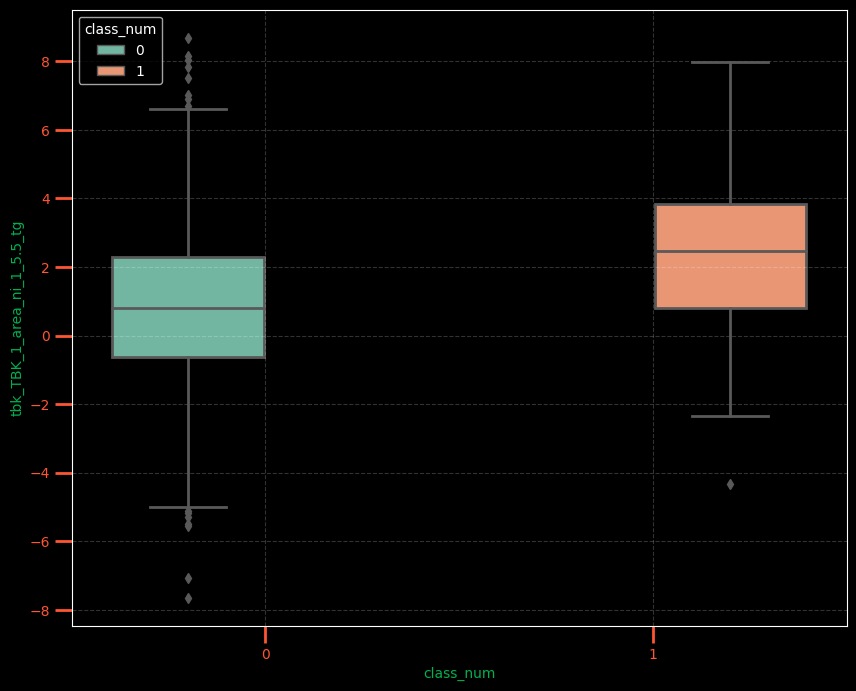

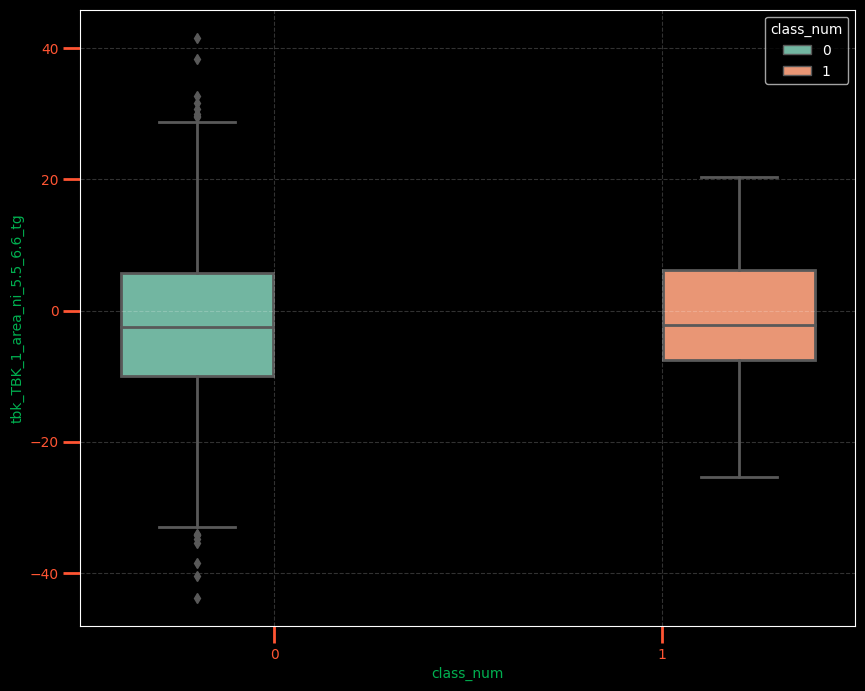

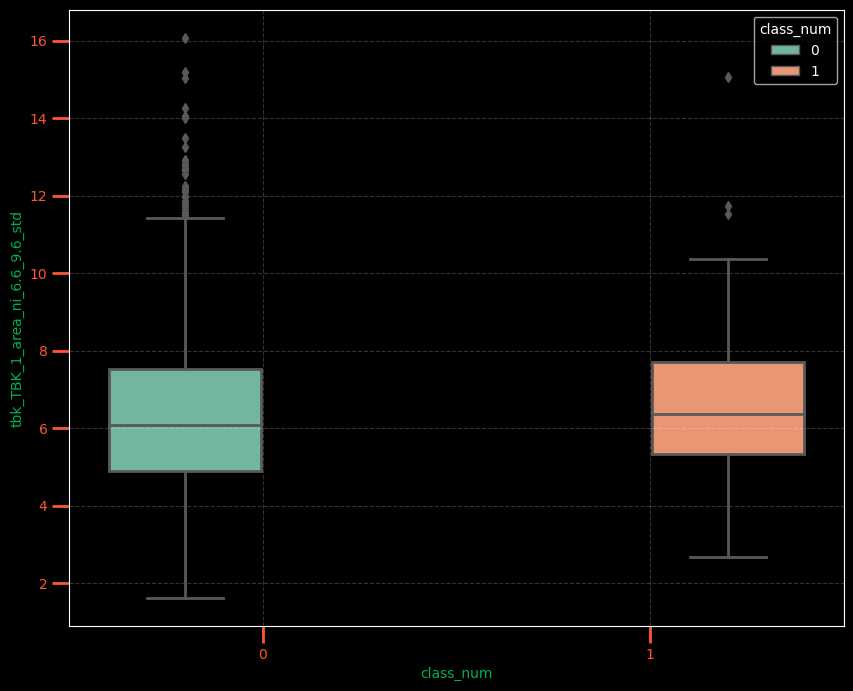

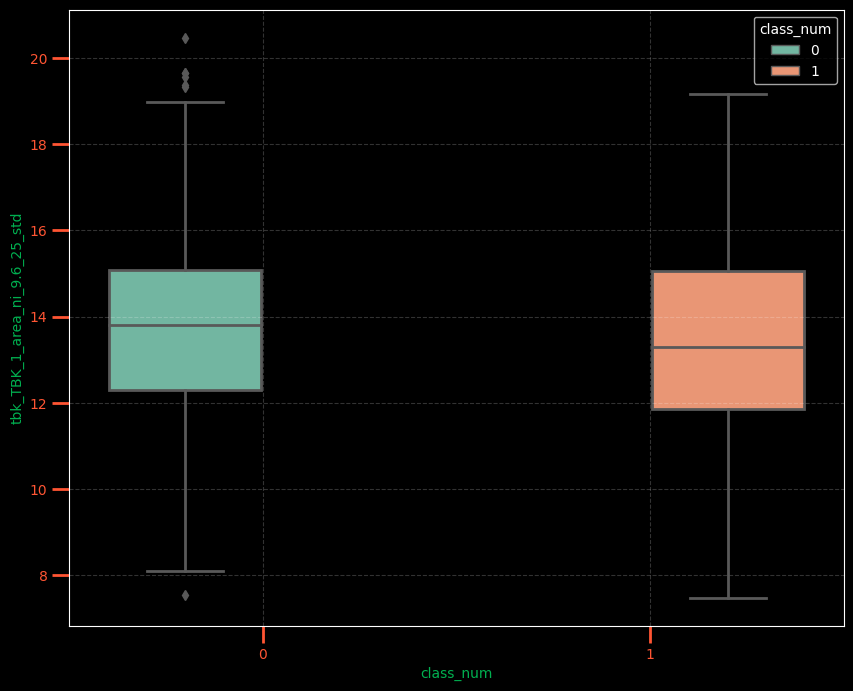

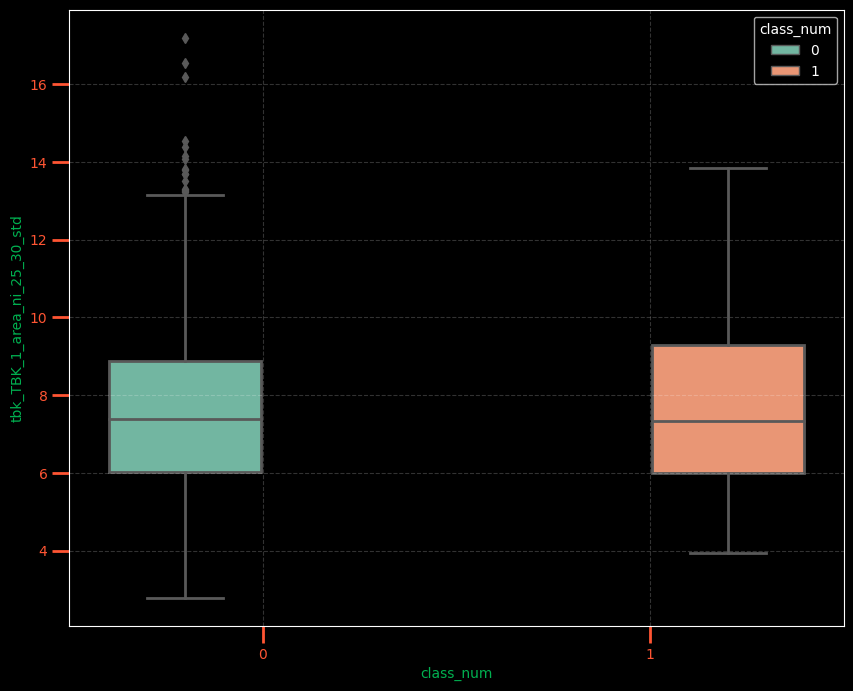

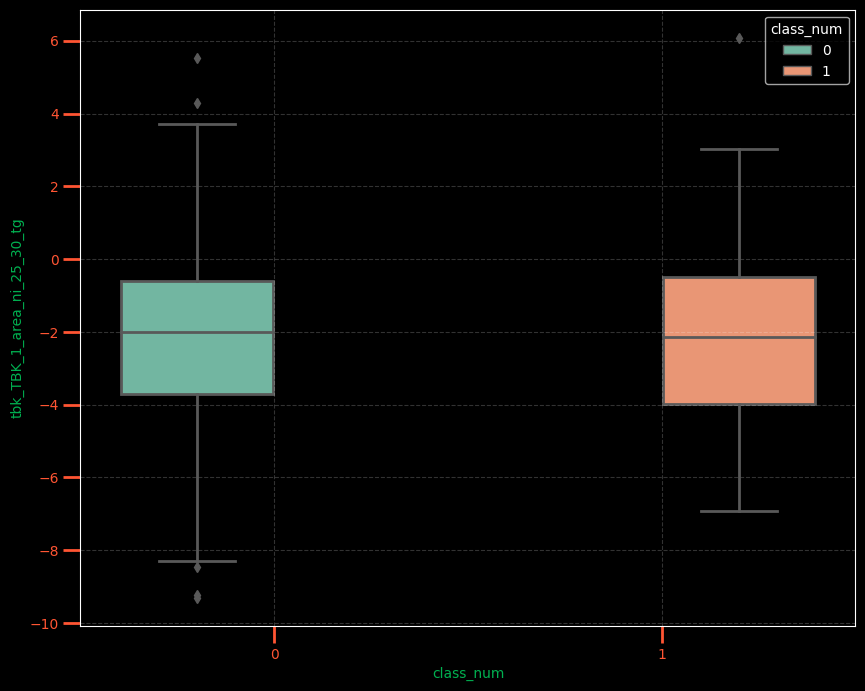

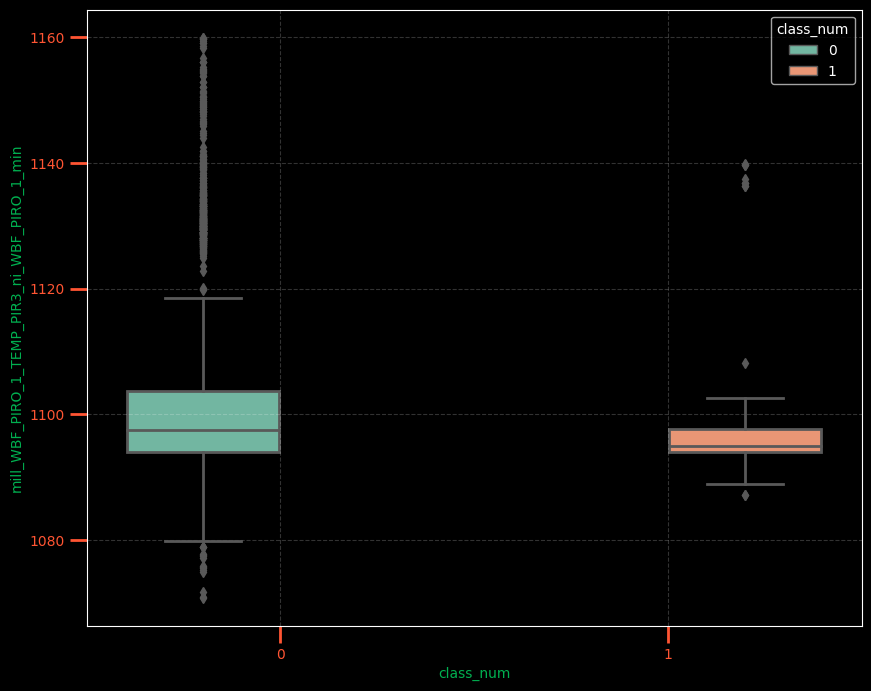

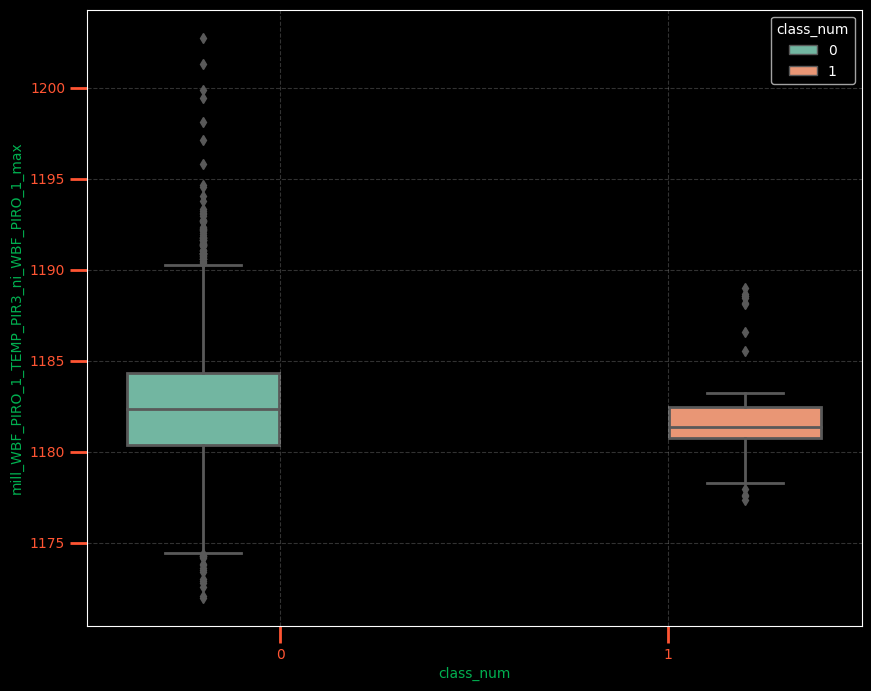

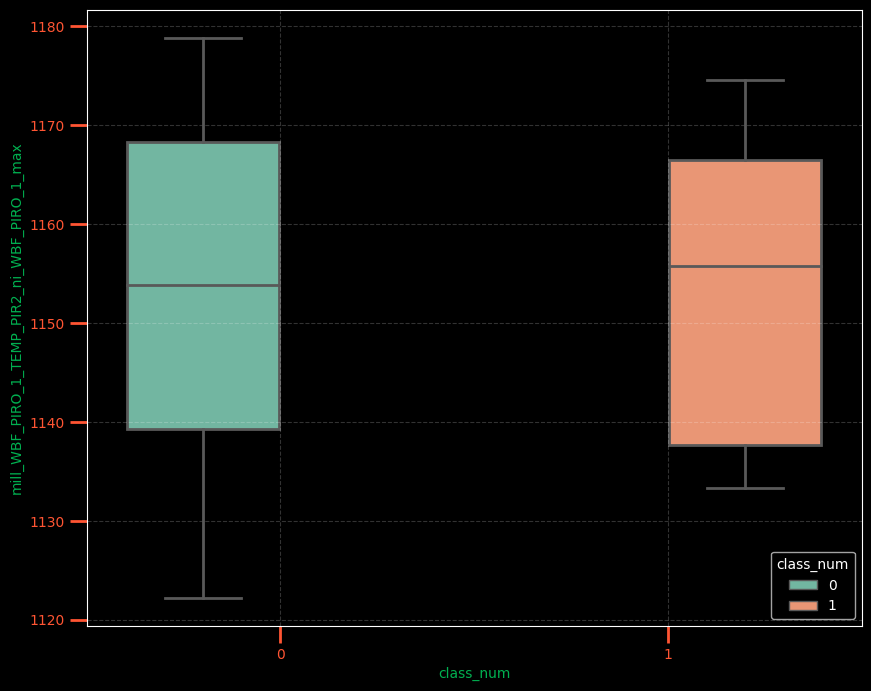

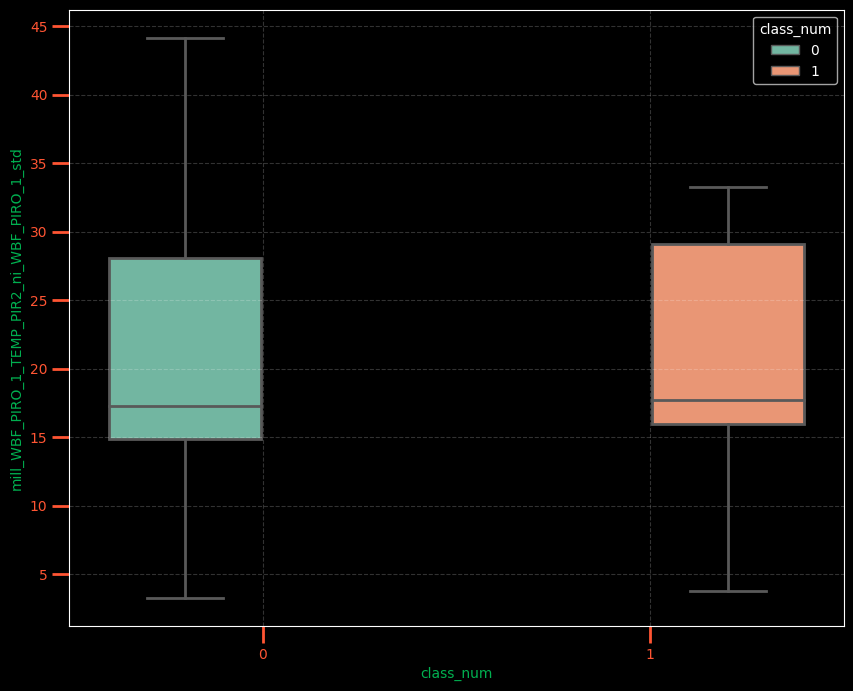

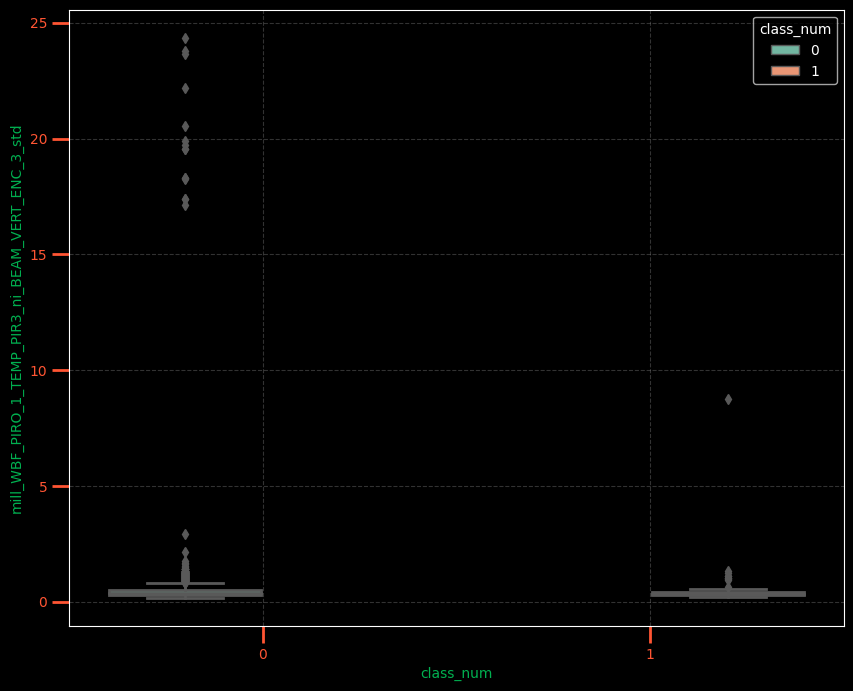

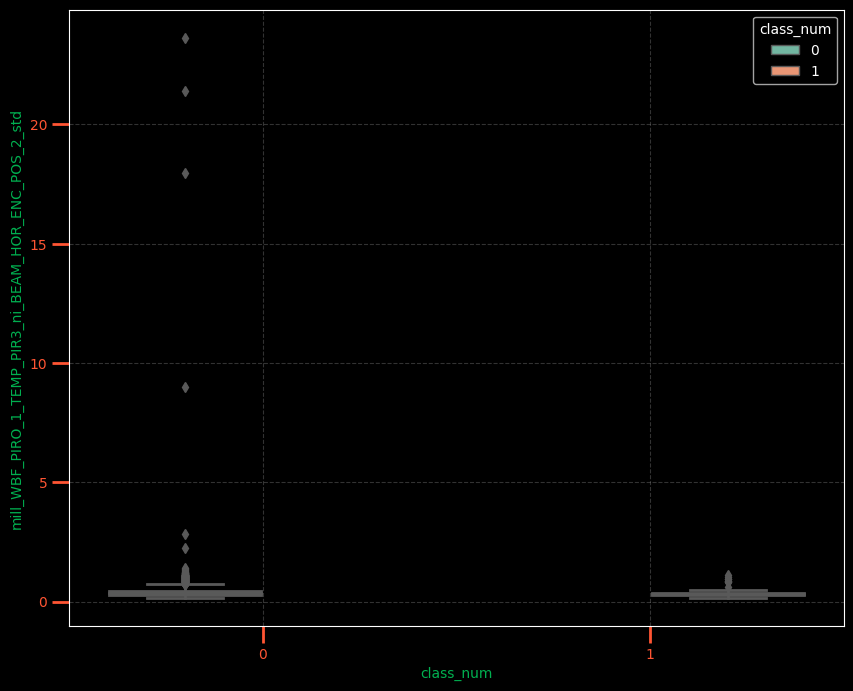

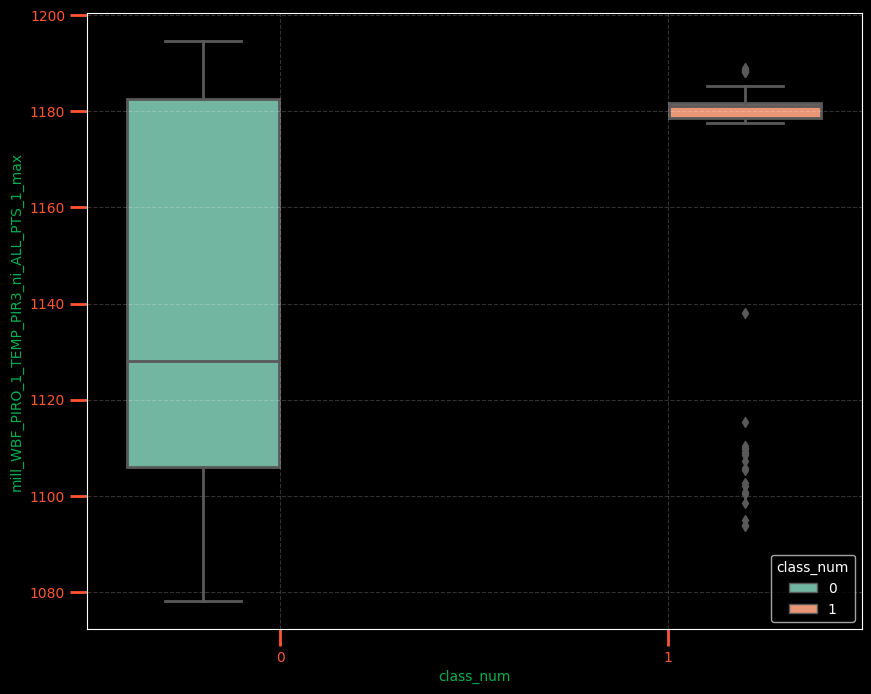

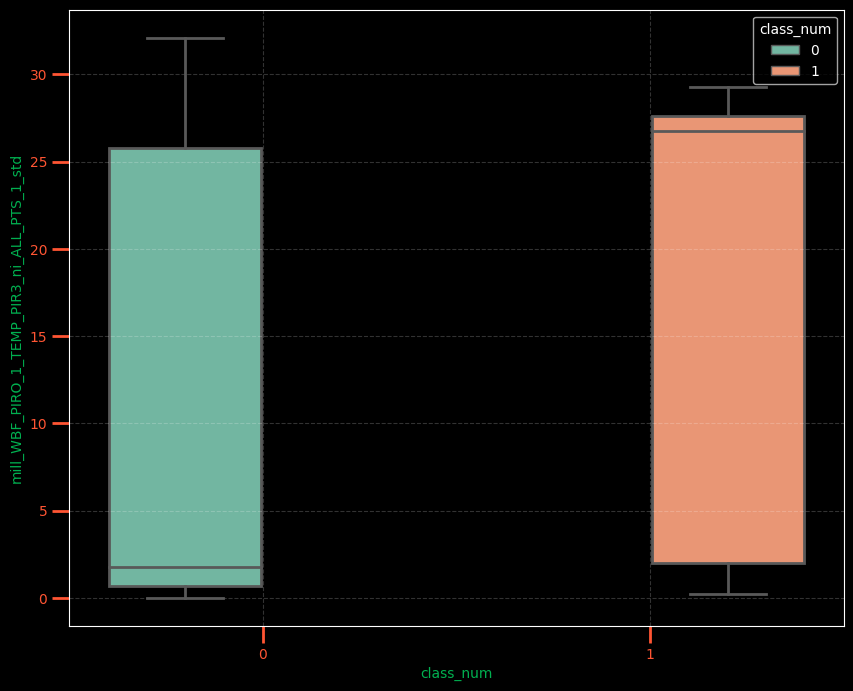

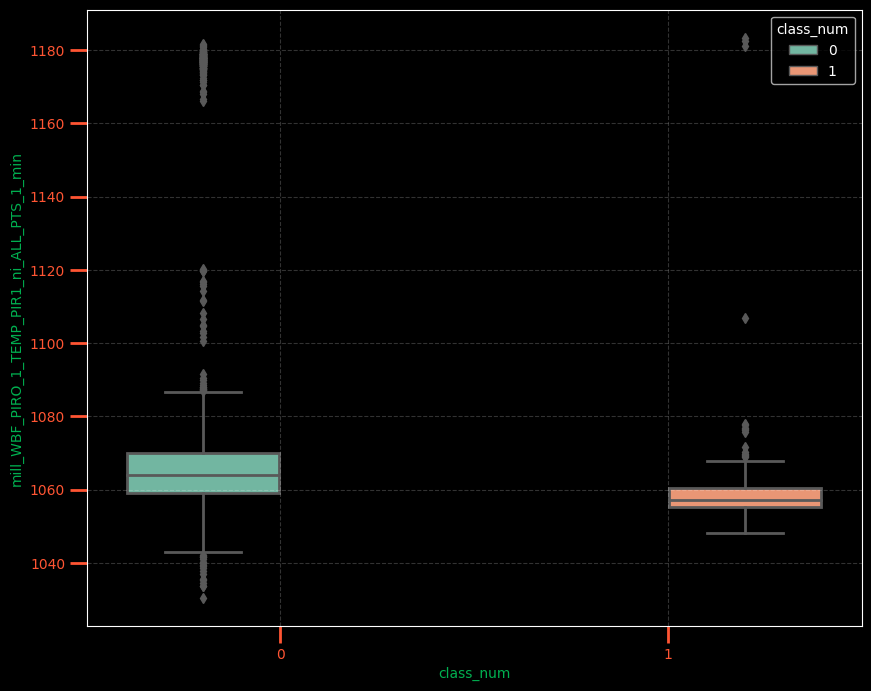

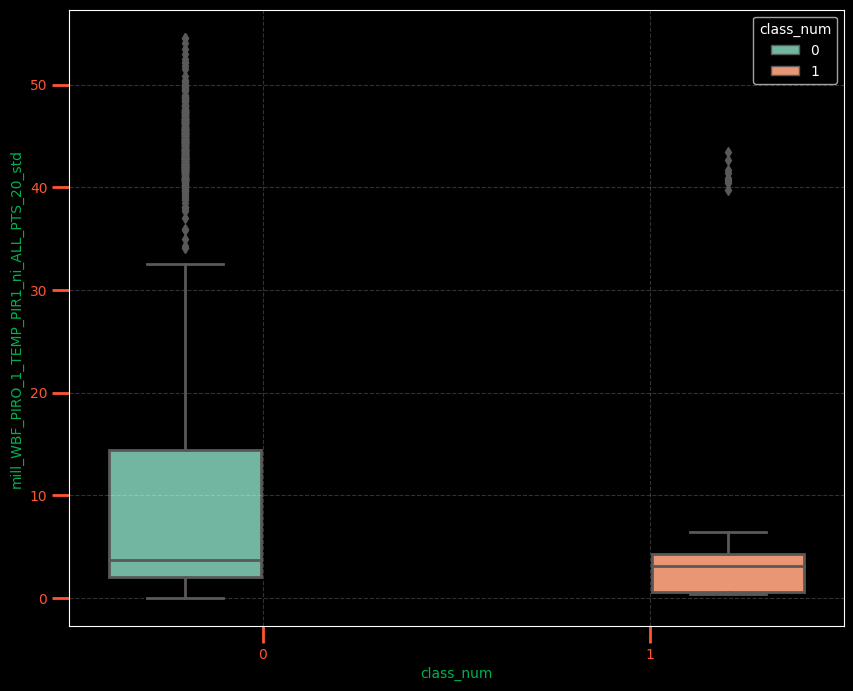

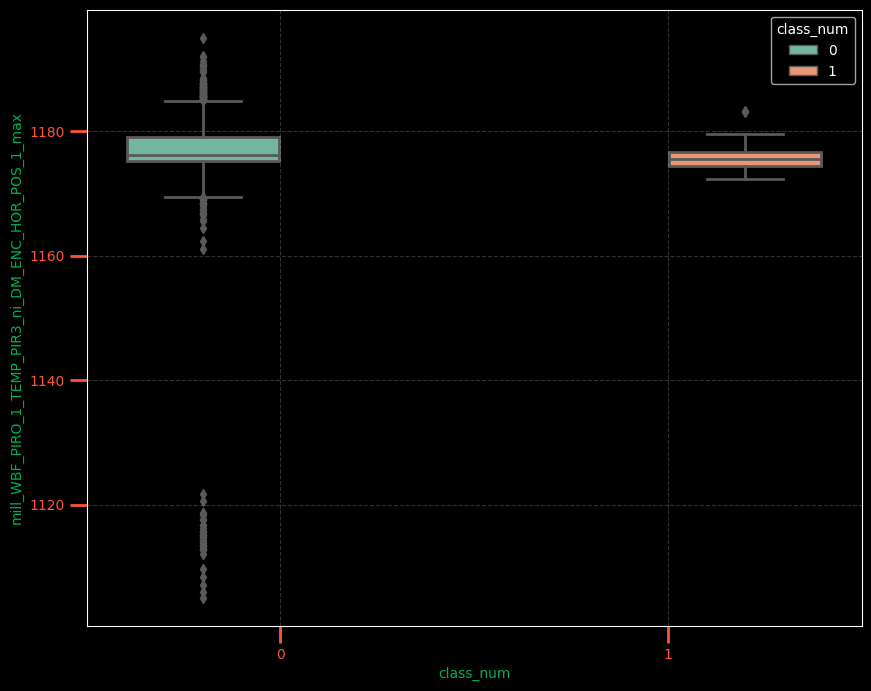

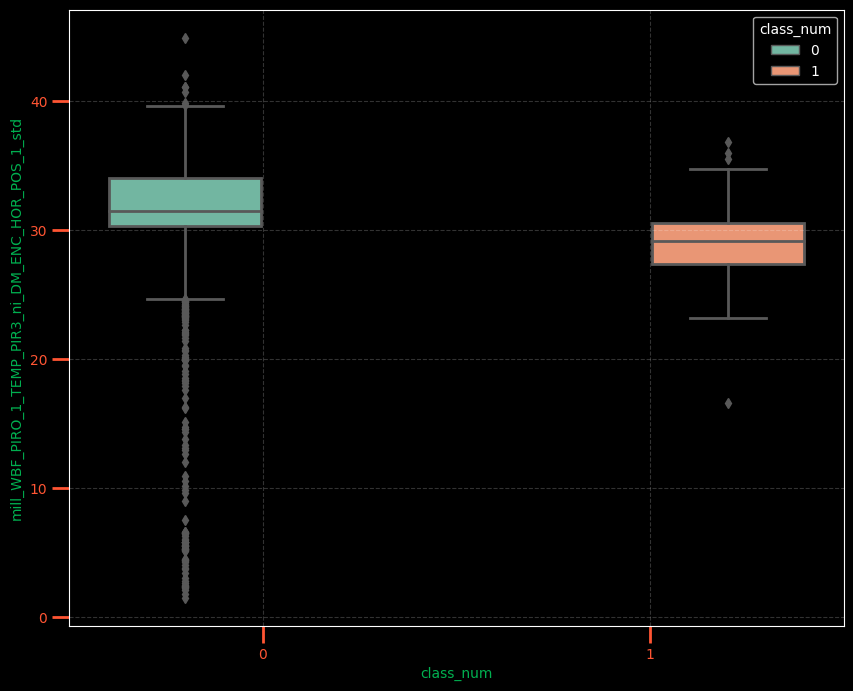

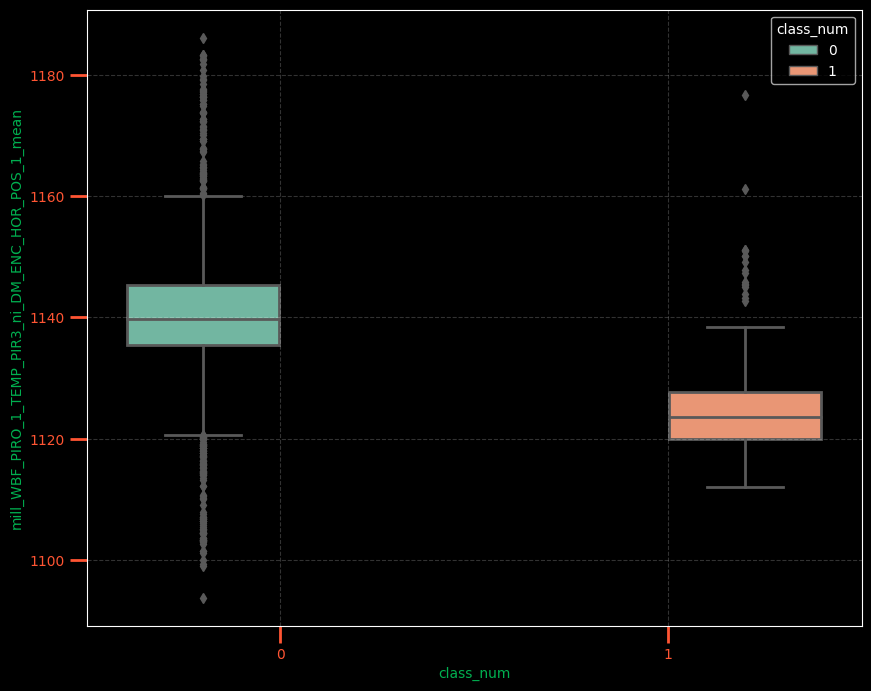

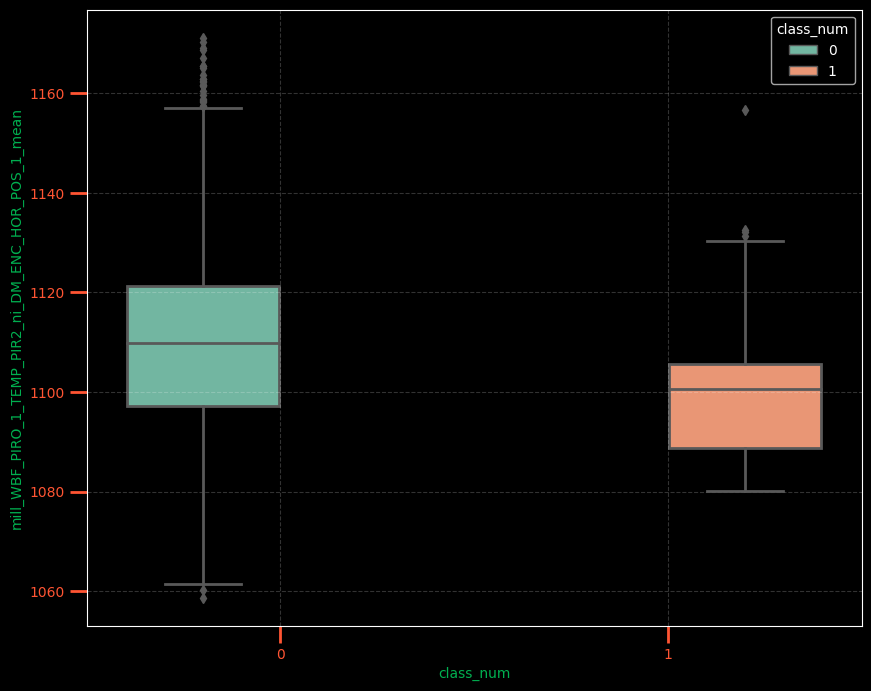

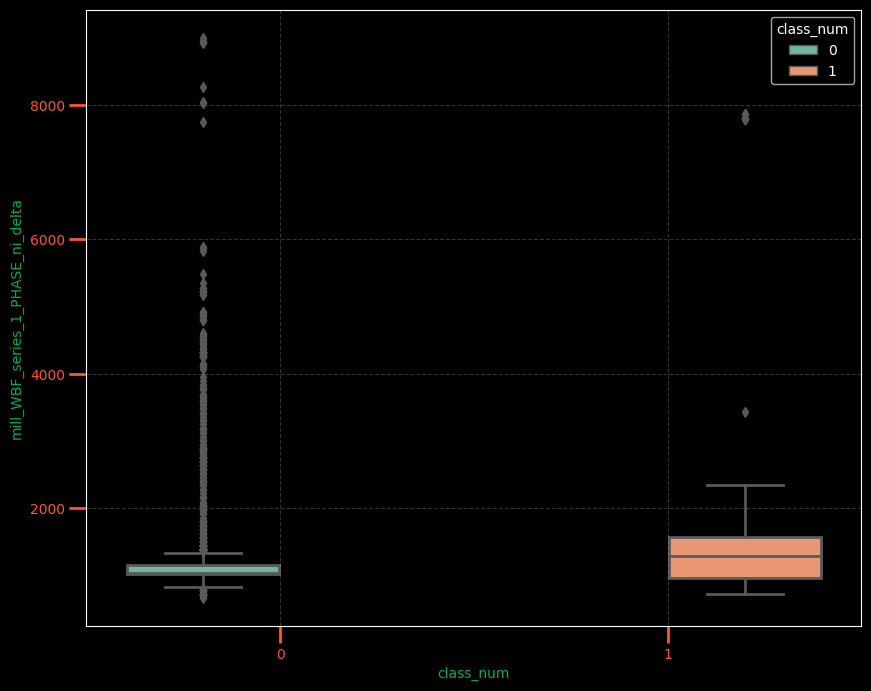

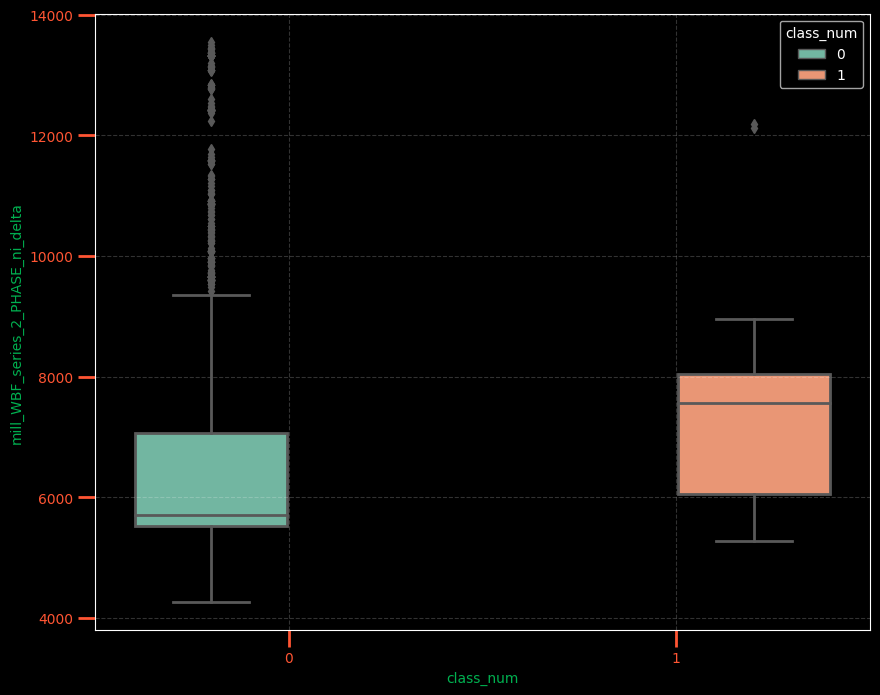

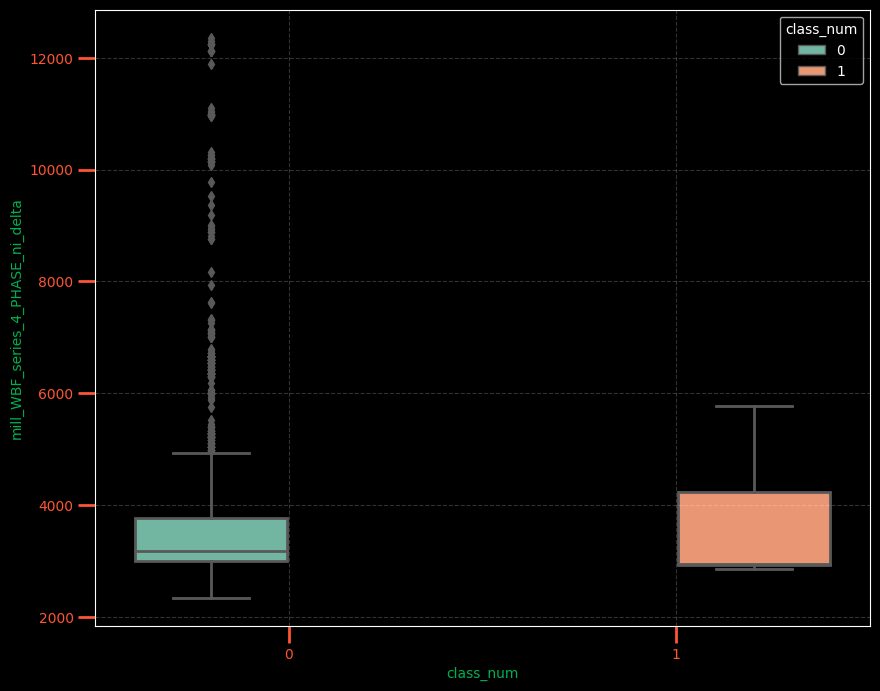

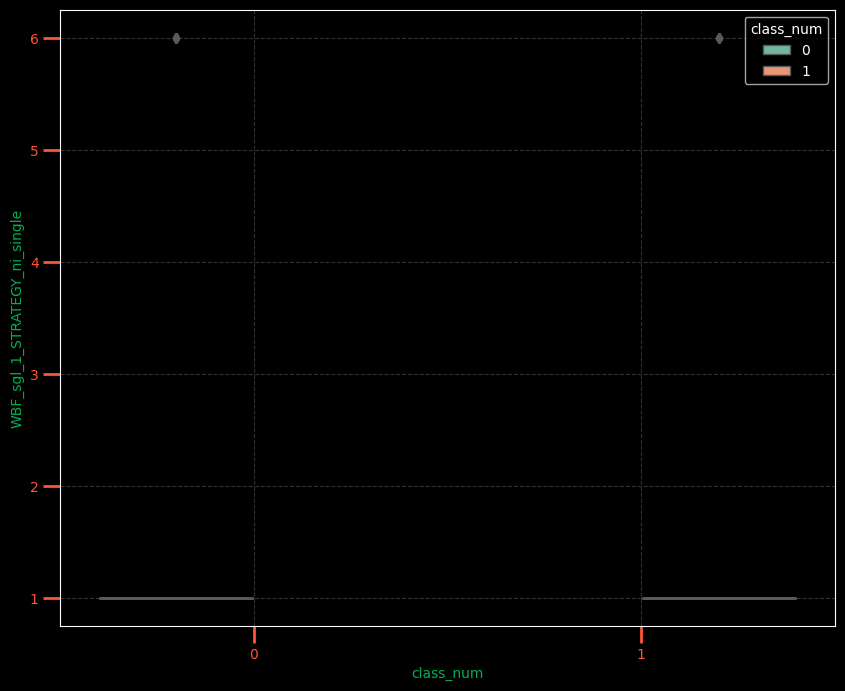

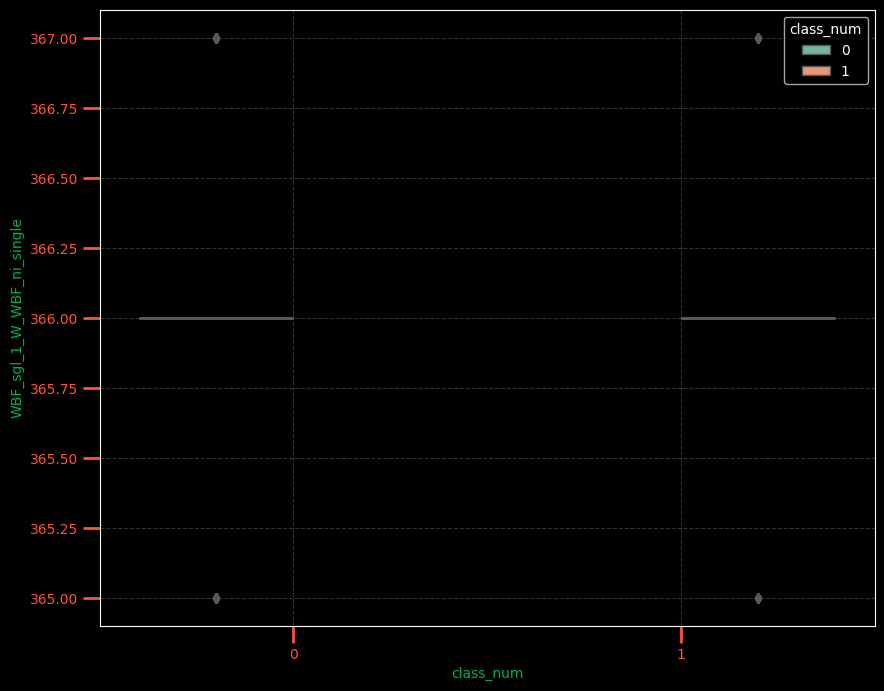

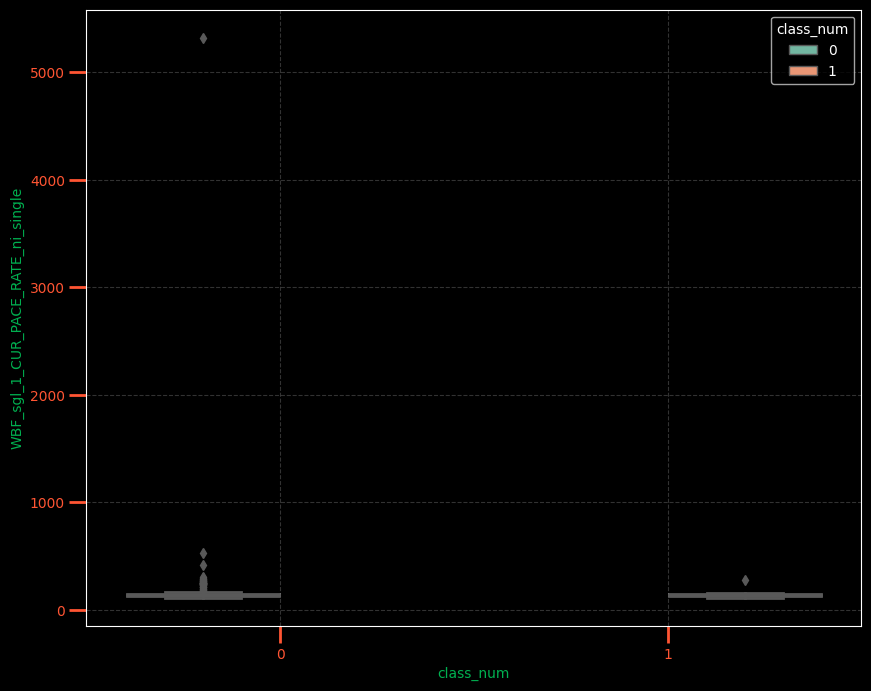

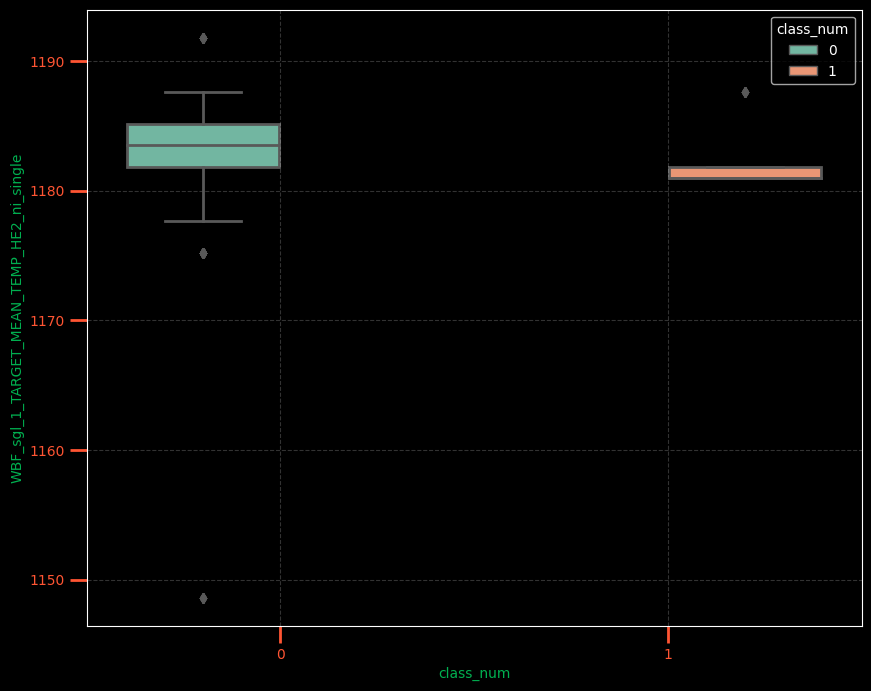

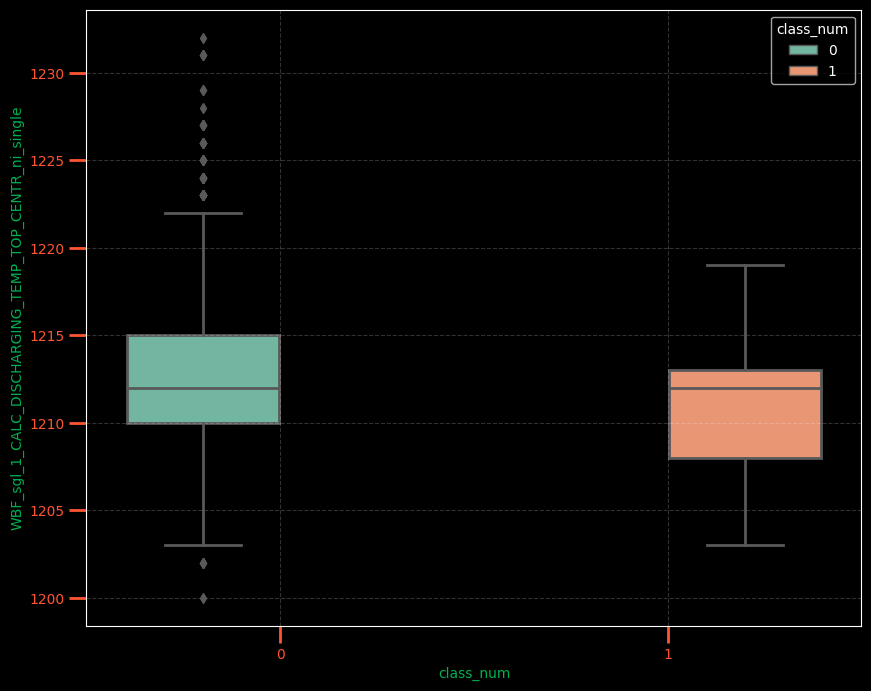

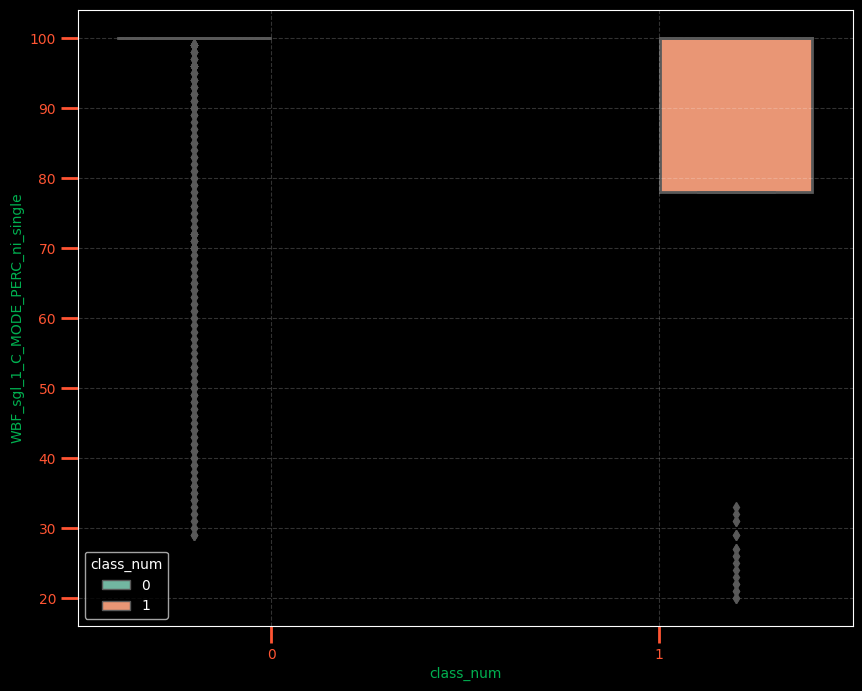

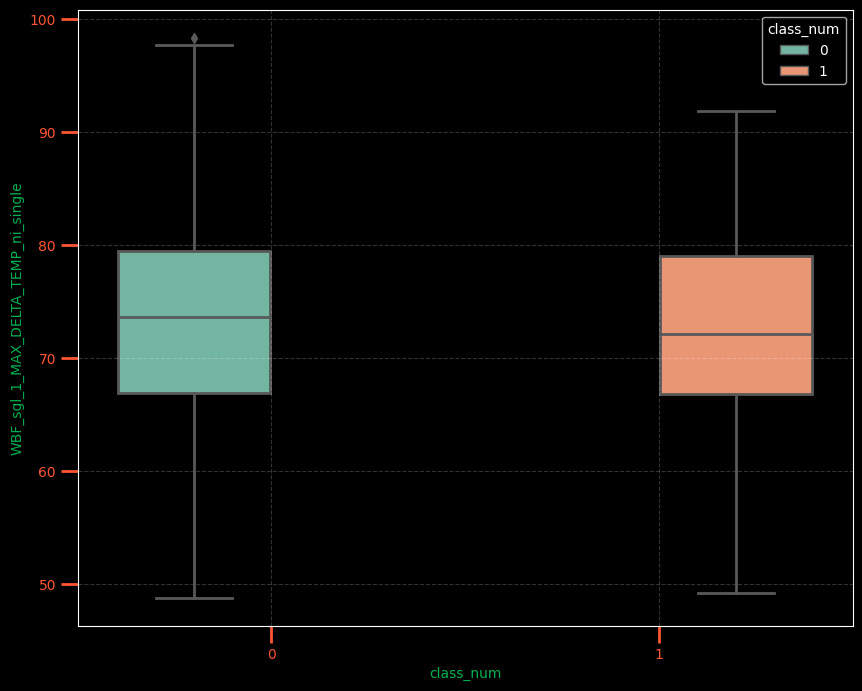

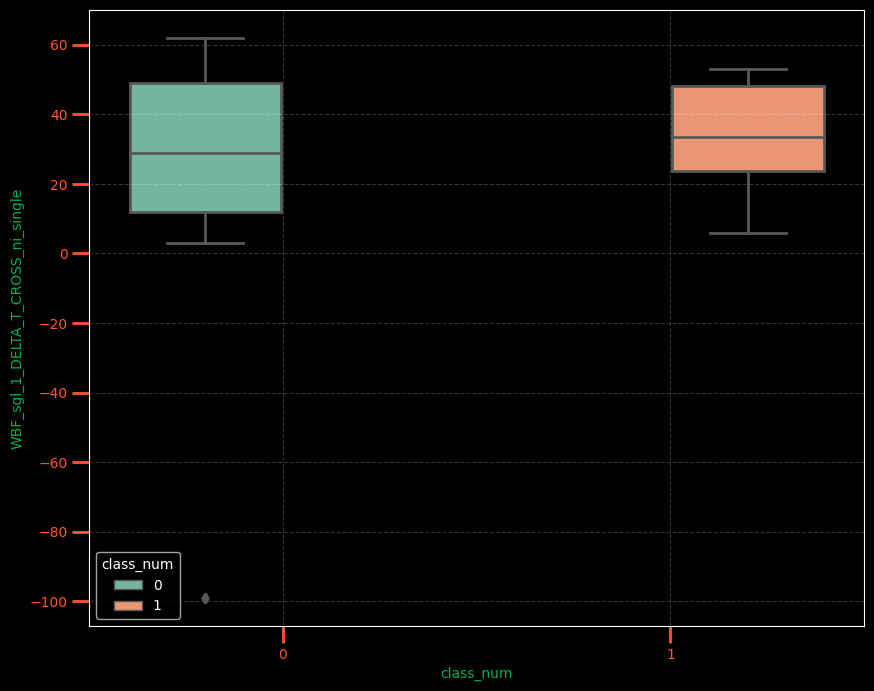

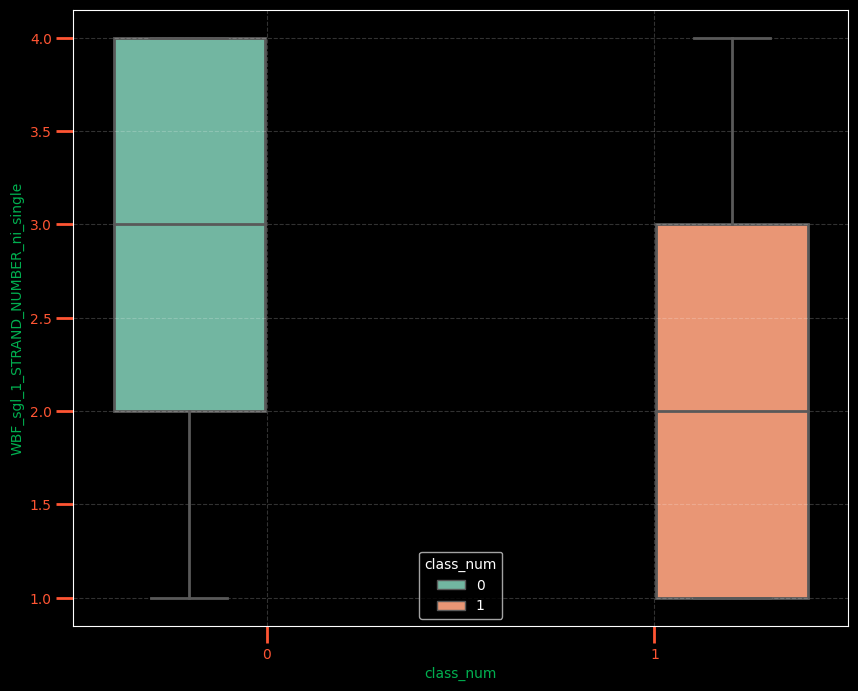

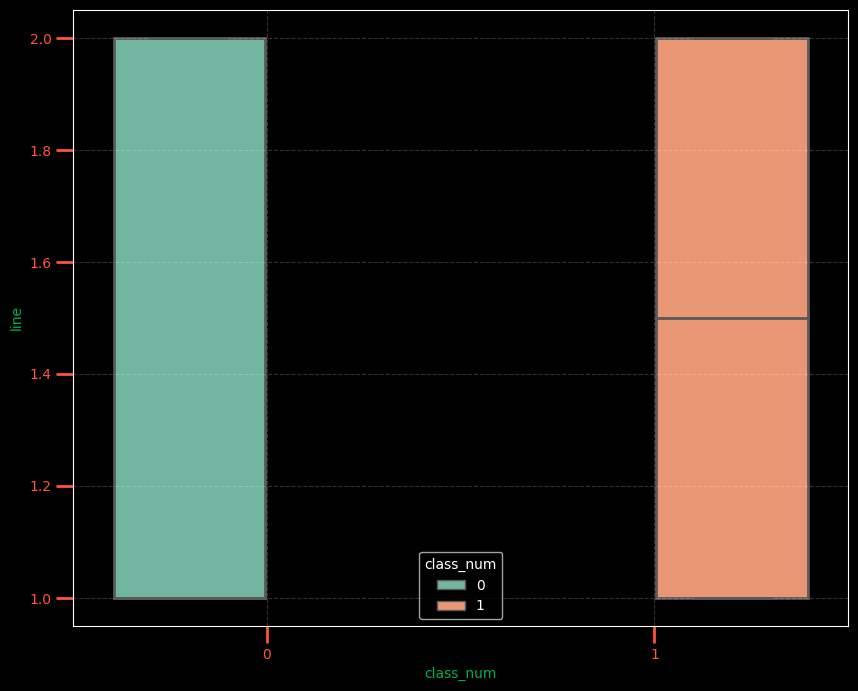

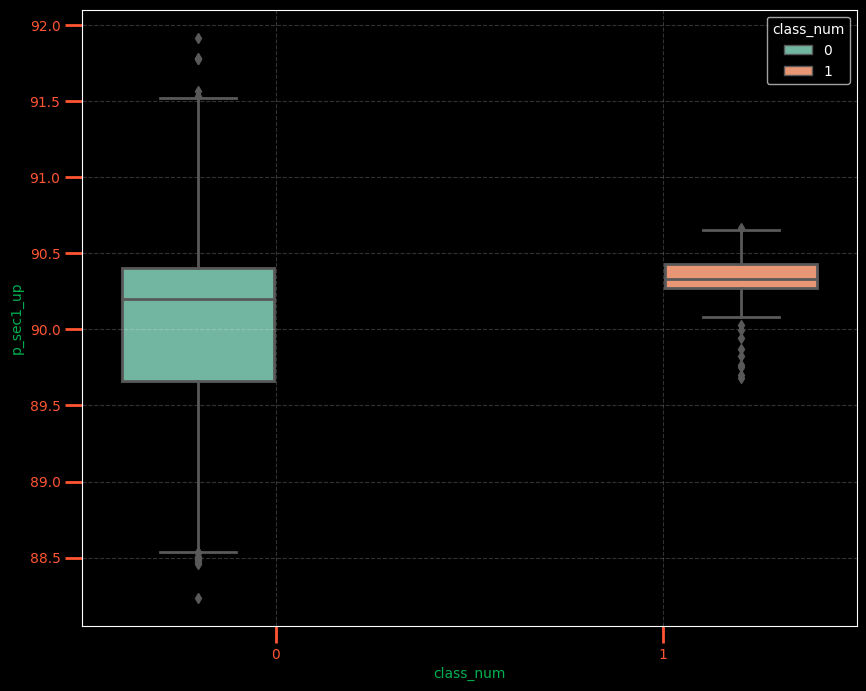

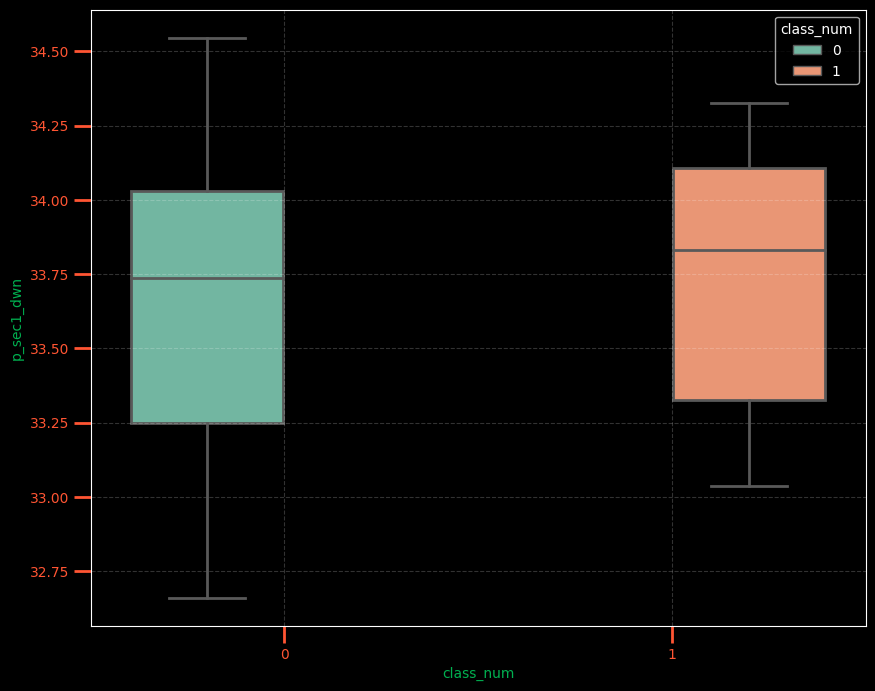

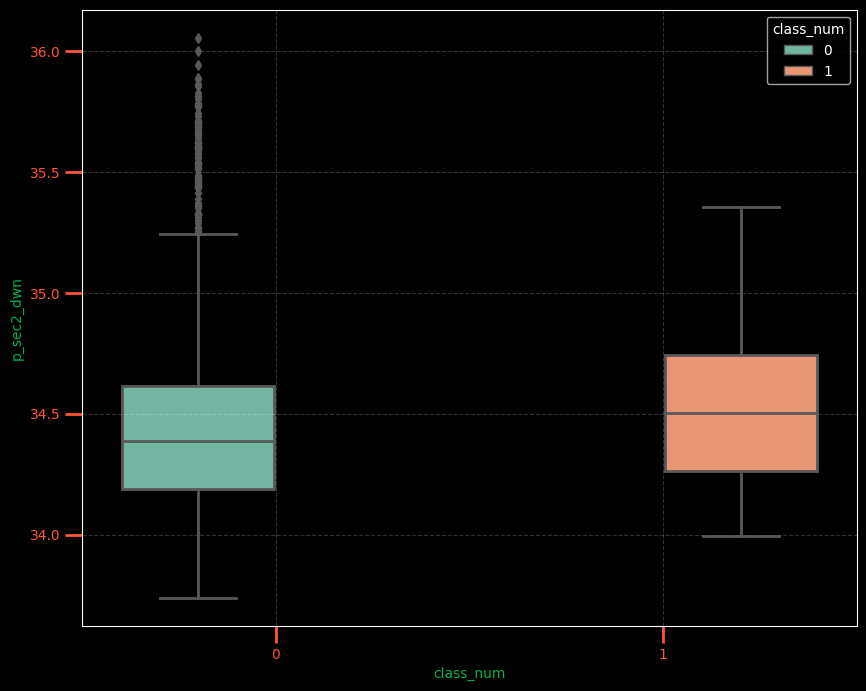

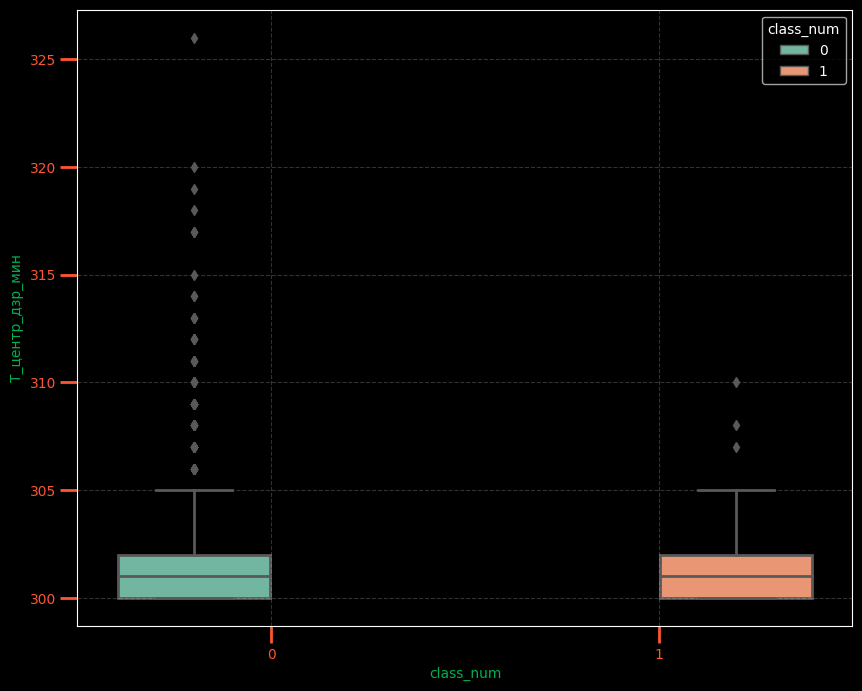

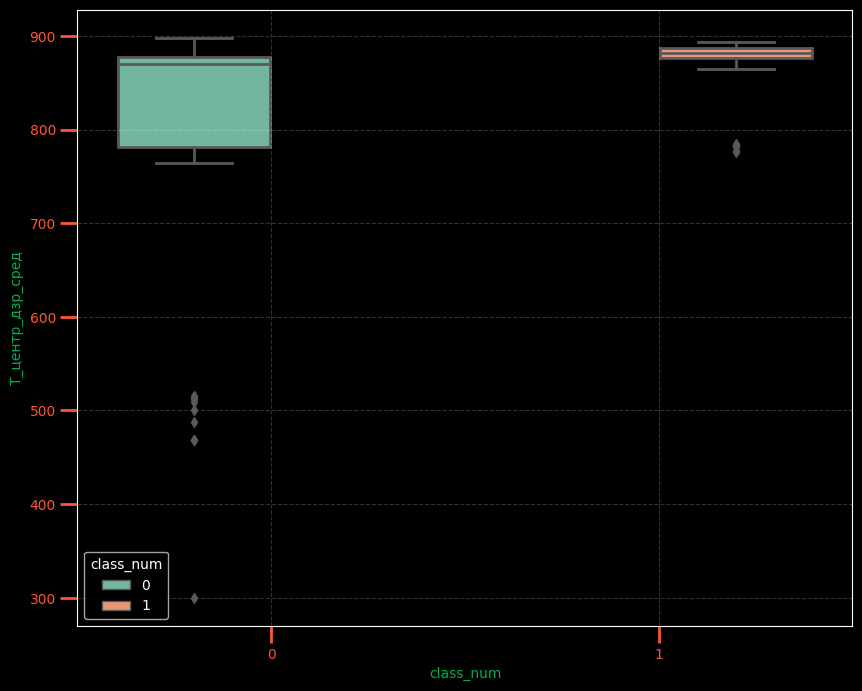

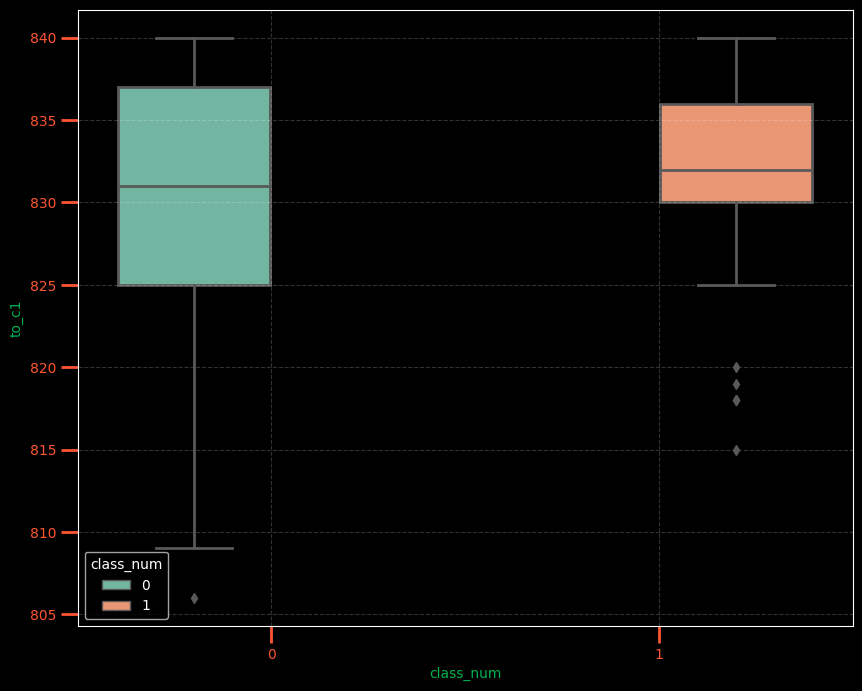

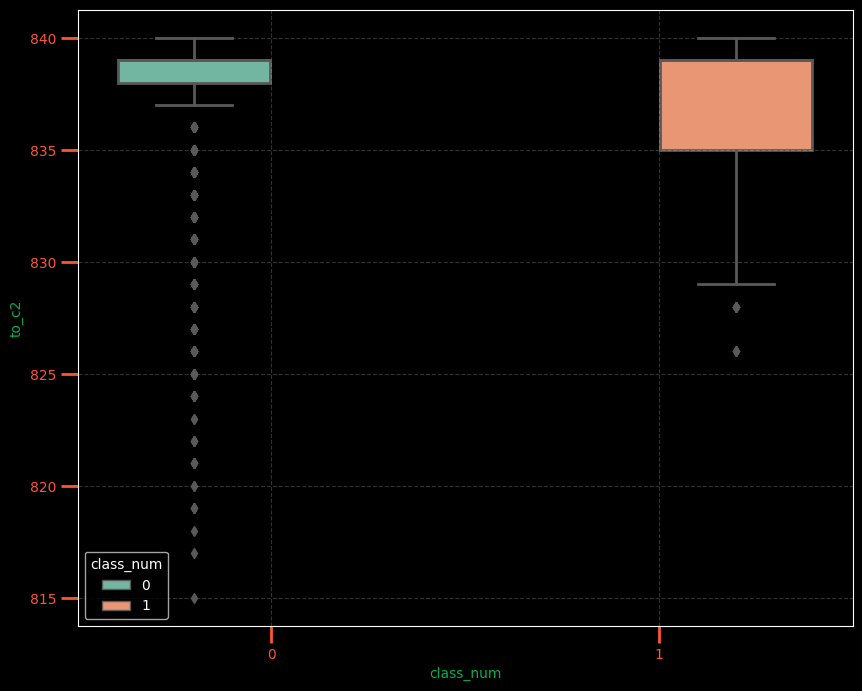

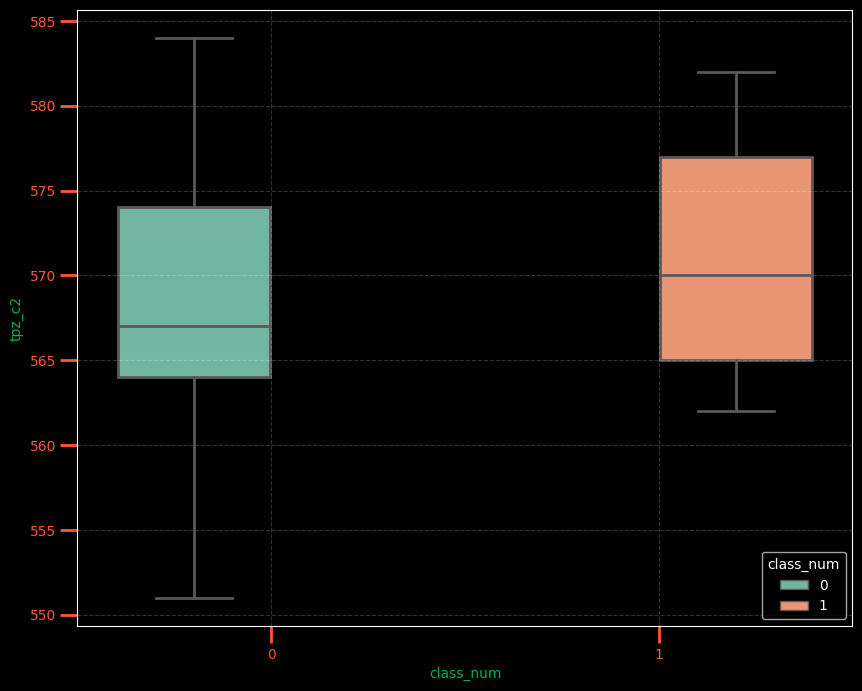

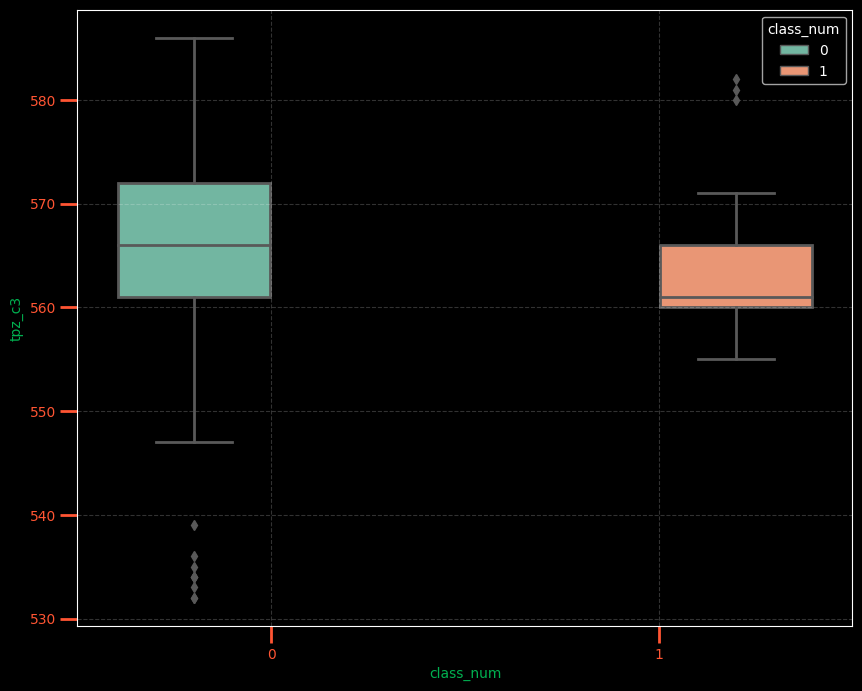

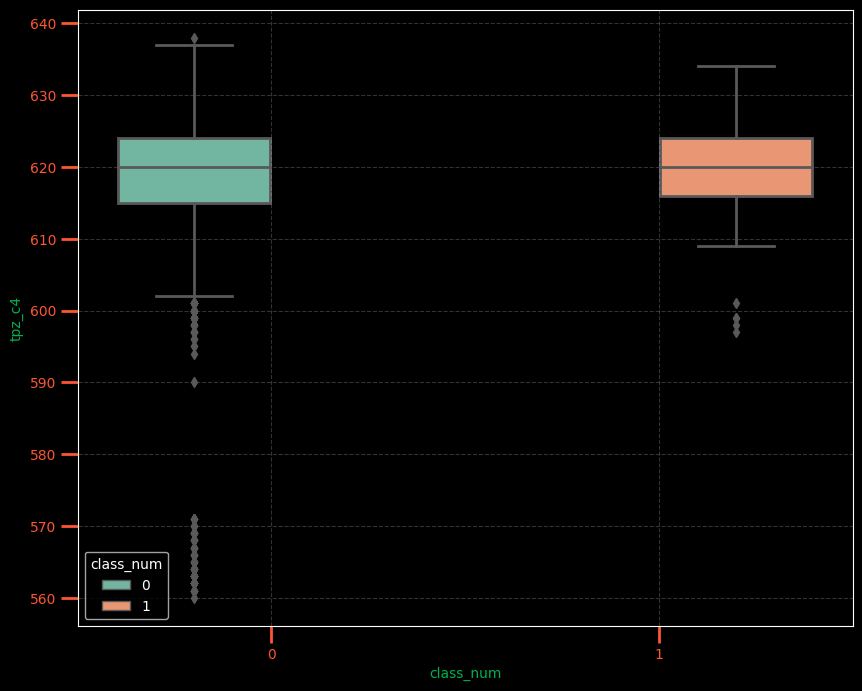

In [50]:
box_plotter = NumericBoxPlot(df_result, 'class_num')
box_plotter.plot()

In [79]:
class OutlierHandler:
    def __init__(self, df):
        self.df = df
        self.outliers = []

    def find_outliers(self, feature, tentacle_length=1.5):
        """
        Находит выбросы в указанном признаке и сохраняет их в self.outliers.

        Параметры:
        - feature: str, имя признака для анализа выбросов.
        - tentacle_length: float, длина усиков в интервале IQR, по умолчанию 1.5.
        """
        q_low = self.df[feature].quantile(0.25)
        q_high = self.df[feature].quantile(0.75)
        iqr = q_high - q_low
        lower_tentacle = q_low - tentacle_length * iqr
        upper_tentacle = q_high + tentacle_length * iqr
        outliers = self.df[(self.df[feature] < lower_tentacle) | (self.df[feature] > upper_tentacle)][feature]
        self.outliers = outliers
        return outliers

    def visualize_outliers(self, feature, tentacle_length=1.5):
        """
        Визуализирует выбросы в указанном признаке с помощью boxplot.

        Параметры:
        - feature: str, имя признака для визуализации выбросов.
        - tentacle_length: float, длина усиков в интервале IQR, по умолчанию 1.5.
        """
        q_low = self.df[feature].quantile(0.25)
        q_high = self.df[feature].quantile(0.75)
        iqr = q_high - q_low
        lower_tentacle = q_low - tentacle_length * iqr
        upper_tentacle = q_high + tentacle_length * iqr
        sns.boxplot(x=self.df[feature], whis=tentacle_length)

In [80]:
handler = OutlierHandler(df_result)
for col in df_result.columns:

    outliers = handler.find_outliers(col)

    cleaned_df = df_result[~df_result[col].isin(outliers)]

### Видно, что при отбросе выбросов мы теряем все объекты 1-го класса и при этом ни одного объекта 0-го класса, из этого можно сделать вывод, что если объект имеет в своих признаках какой-то выброс, то скорей всего он принадлежит к классу 1, то есть имеет 3 и более дефектов.

In [81]:
# Было 2218 объектов, при этом 92 из них ушло, получили 2126 объектов, принадлежащих к классу 0.
cleaned_df.shape

(2126, 51)

In [82]:
cleaned_df.groupby('class_num').size()

class_num
0    2126
dtype: int64

In [83]:
df_result.shape

(2218, 51)

In [84]:
df_result.groupby('class_num').size()

class_num
0    2126
1      92
dtype: int64

### Тогда оставляем данные для дальнейшего обучения моделей

In [51]:
file_path = "./data_store/dzr_data_90HAF_with_wbf_stan_50_features.csv"
df_result.to_csv(file_path, sep=',', index=False)

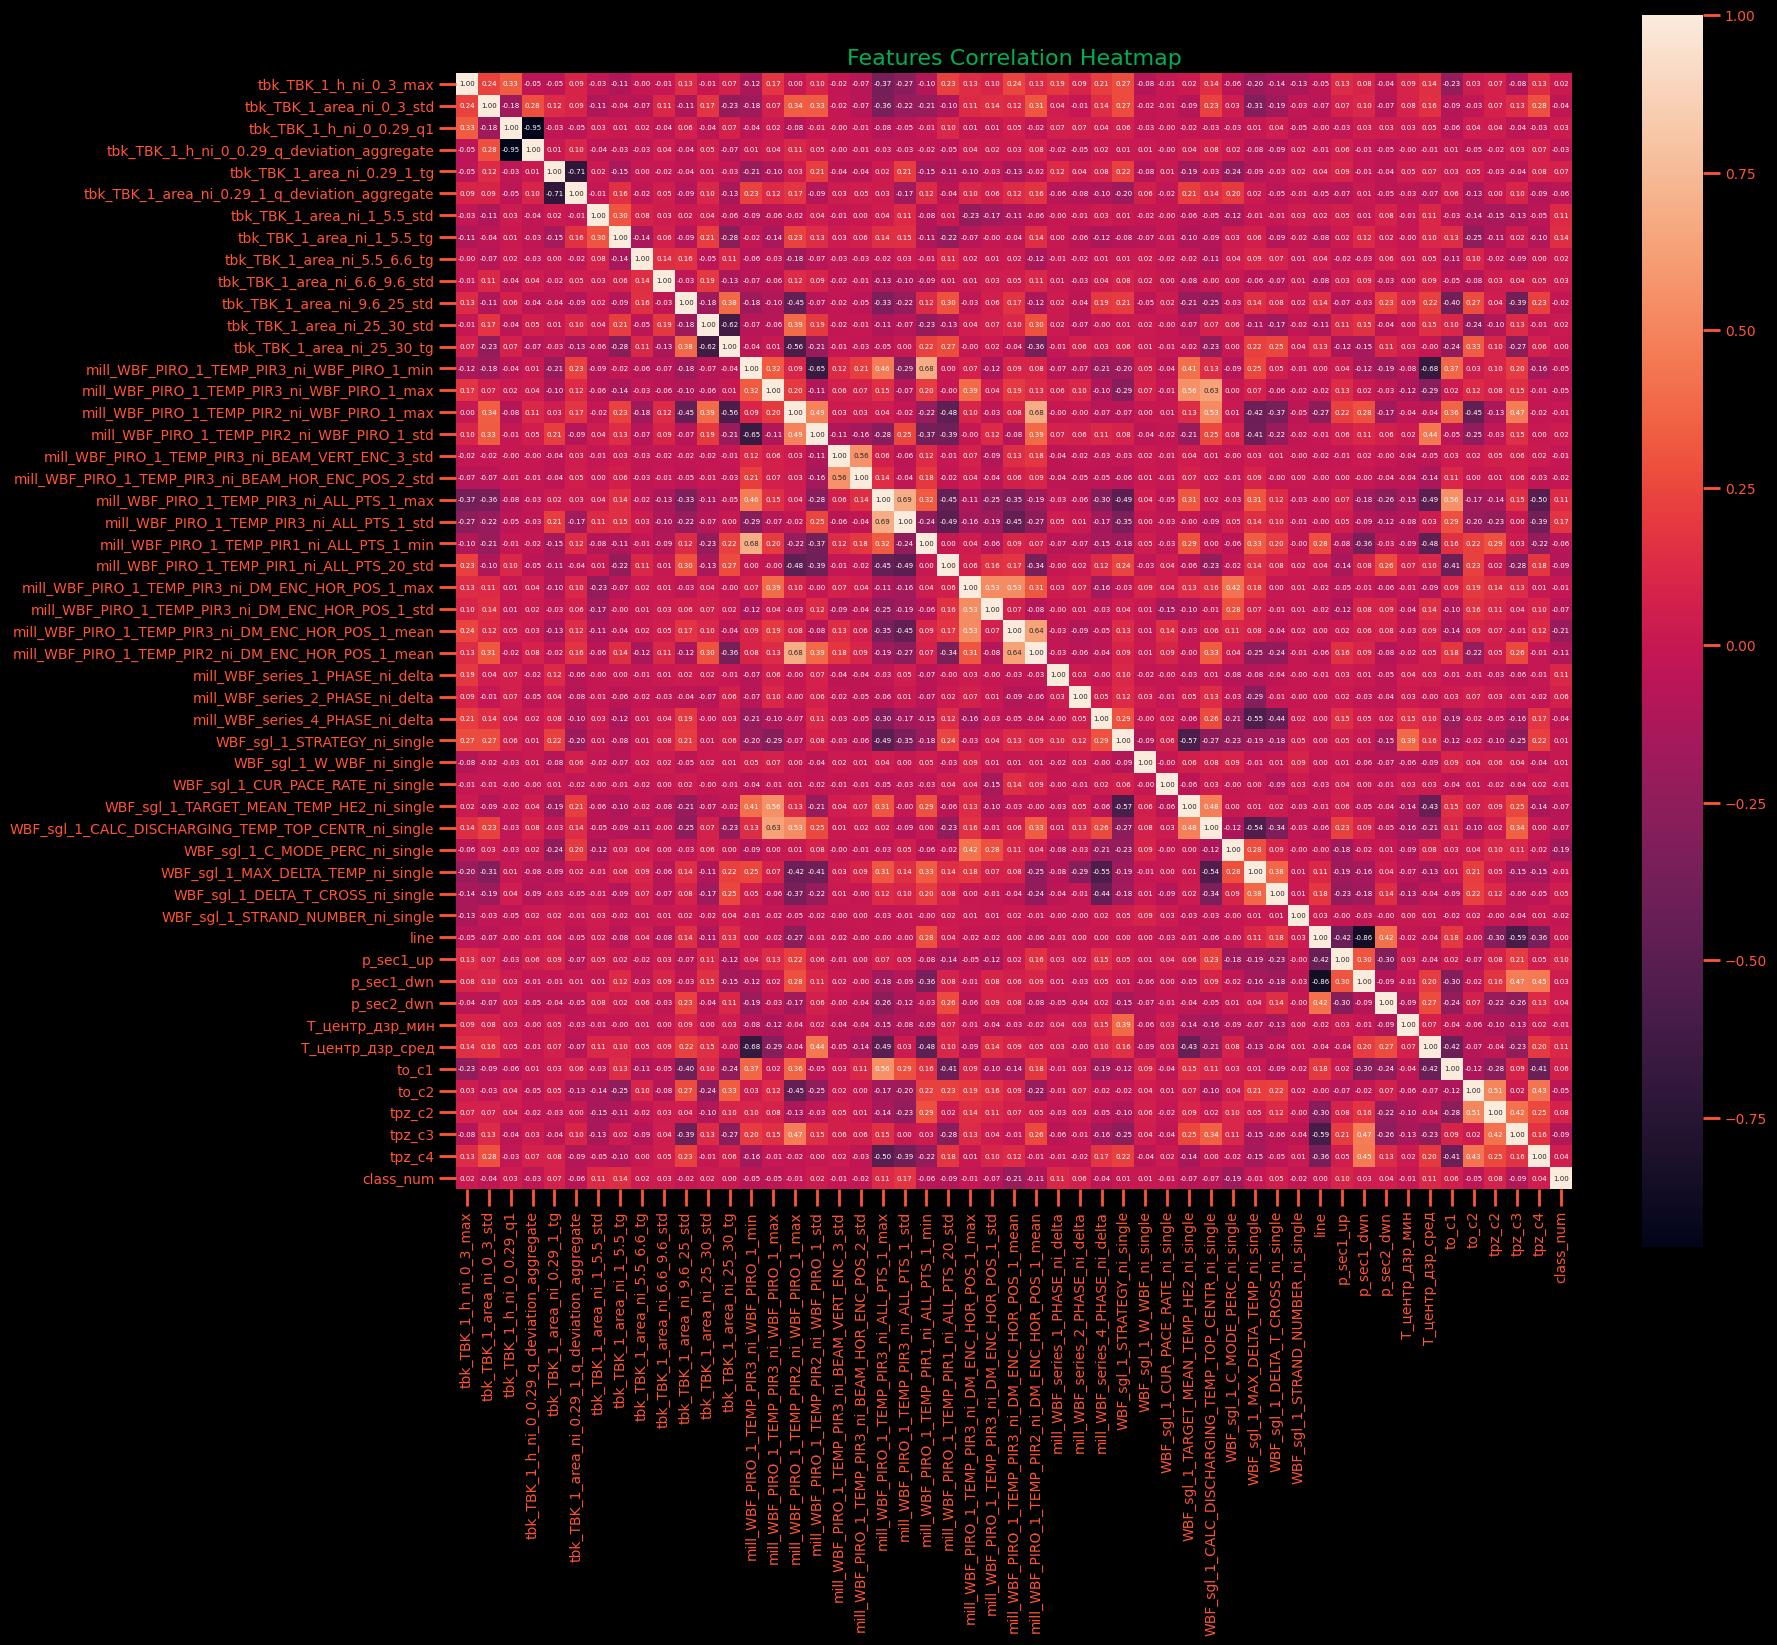

In [58]:
numeric_columns = [col for col in df_result.columns if df_result[col].dtype != 'object']
cm = np.corrcoef(df_result[numeric_columns].values.T)
fig = plt.figure(figsize=(18, 16))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 5}, yticklabels=numeric_columns, xticklabels=numeric_columns)
plt.title('Features Correlation Heatmap')
plt.show()